In [1]:
import warnings
warnings.filterwarnings('ignore')

import math

#mostly read file function
import numpy  
import pandas as pd
import glob
import numpy as np
import pickle
import joblib

from numpy import sqrt

from skimage.transform import pyramid_reduce, resize

#img function
import cv2 as cv
#thresholding filtering
import skimage.filters as filters

#ploting img or diagram function
import matplotlib.pyplot as plt

#train test split(split the dataset)
from sklearn.model_selection import train_test_split

#img preprocessing function
from sklearn.decomposition import PCA

#shuffle the list
from sklearn.utils import shuffle
                        
#to get the optimal parameter for the model
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#getting result tools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import seaborn as sns
import matplotlib

%matplotlib inline

from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation

#preprocessing part
from skimage.segmentation import clear_border
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import ball, disk, binary_erosion, remove_small_objects, reconstruction, binary_closing, binary_opening
from skimage.filters import roberts, sobel
from scipy import ndimage as ndi

#plot 3d
from skimage import measure, feature
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

###############################################################################################################################

# Table Content
## 1.0 Read Data
1. Get Image Path
2. Read Image

## 2.0 Image Pre-processing
1. Show Original Image
2. Segment Lung Image
3. Get Nodules
4. Plot 3D Nodules For Visualization

## 3.0 Training
1. 

###############################################################################################################################

###############################################################################################################################

# Function Used:
## 1.0 Plotting Image Purpose
1. plot_img(images, titles, camp='gray', rows = 3, cols = 4, fontsize=50, top=10, right=10)
2. image_show(image, title, nrows=1, ncols=1, cmap='gray')

## 2.0 Segment Lung Image
1. get_segmented_lungs(im, plot=False)

## 3.0 Get Nodules
1. get_nodules_lungs(im, plot=False)

## 4.0 Plot 3D Visualization
1. plot_3d(image, threshold=-300)

###############################################################################################################################

###############################################################################################################################
# 1.0 Read Data
### 1.1 Get img path
Original:
1. train 1025 
2. test 72

After data augmentation:
1. train 1313
2. test 72

In [2]:
#get all classes names
classes = ["Bengin","Malignant","Normal"]

#get all images location(total 1097 img)
img_list = sorted(glob.glob('dataset/*/*/*.*'))
print('Total: ', len(img_list))

#get all images location(total 1097 img)
train_list = sorted(glob.glob('dataset/train/*/*.*'))
print(len(train_list))

#get all images location(total 1097 img)
test_list = sorted(glob.glob('dataset/test/*/*.*'))
print(len(test_list))

Total:  1385
1085
300


In [7]:
#Define variable to hold X & y
#create numpy array placeholder for pixels with 1 channel(grayscale)
IMG_SIZE = 528
CHANNEL = 1
#arg: (length of numpy set, height, width, color channel)
X = np.empty((len(img_list), IMG_SIZE, IMG_SIZE), dtype=np.uint8)

y = []

### 1.2 Read Image

In [8]:
# convert images to numpy arrays
for i, img_path in enumerate(img_list):
    # load image
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (IMG_SIZE, IMG_SIZE))
    X[i] = img
    y.append("Benign") if img_path.find(classes[0]) != -1 else (y.append(classes[1]) if img_path.find(classes[1]) != -1 else y.append(classes[2]))
    
y = pd.Series(y)

# Plotting Image Purpose

In [9]:
#plot image with title
def plot_img(images, titles, camp='gray', rows = 3, cols = 4, fontsize=50, top=10, right=10):
    plt.subplots_adjust(top=top,right=right)
    for i in range(len(images)):
        #(rows, columns, index)
#         fig, ax = subplots(figsize=(18, 2))
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[i], cmap=camp)
        plt.title(titles[i], fontsize=fontsize)
        plt.xticks([])
        plt.yticks([])
        
#define a function to plot the images
def image_show(image, title, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4,4))
    ax.imshow(image, cmap=cmap)
    ax.set_title(title)
    ax.axis('off')
    return fig, ax

###############################################################################################################################
# 2.0 Image Pre-processing
### 2.1 Show Original Image

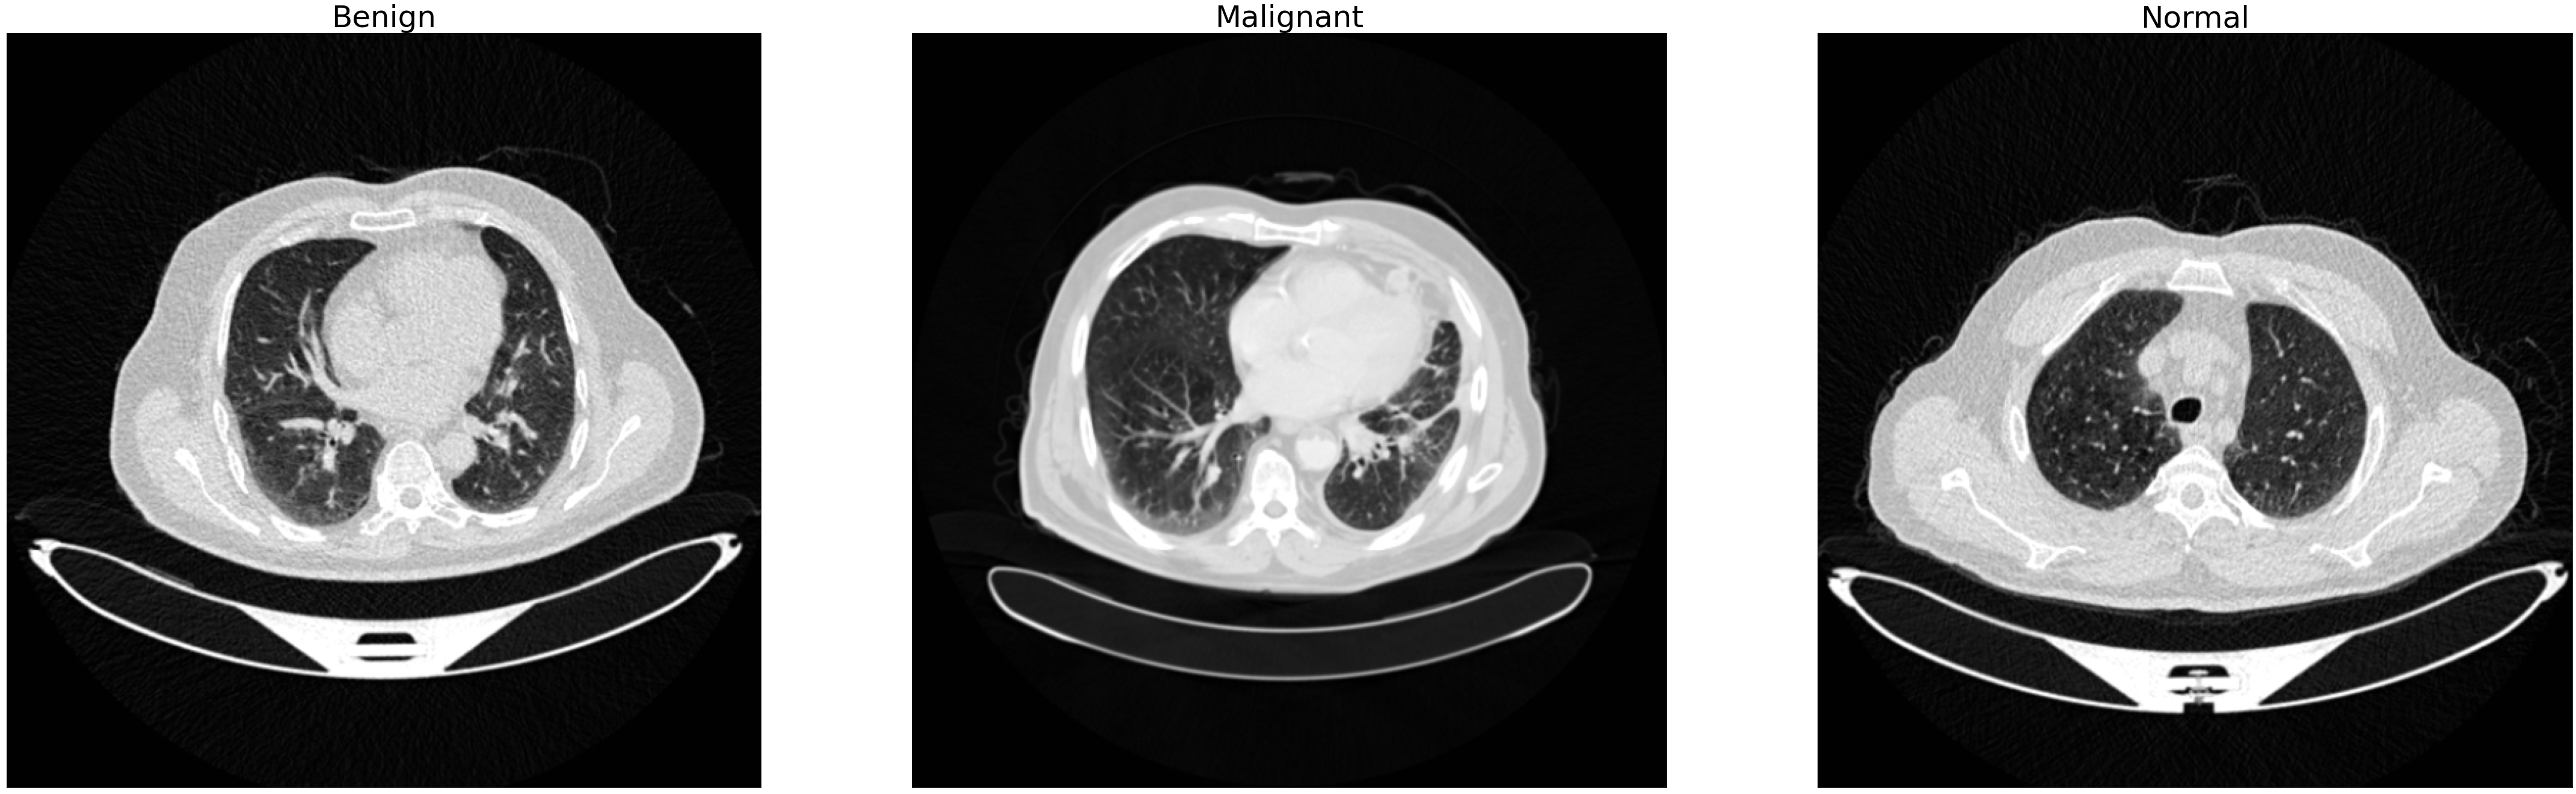

In [10]:
#show ori img
images = [X[0], X[100], X[200]]
titles = [y[0], y[100], y[200]]
plot_img(images, titles, rows = 2, cols = 3)

### 2.1 Segment Lung Image <br>
Credit to ARNAVJAIN from Kaggle: https://www.kaggle.com/code/arnavkj95/candidate-generation-and-luna16-preprocessing
<br><br>
Steps to do:
1. Crop the image to enlarge the lung
2. Convert image to a binary image
3. Remove the blobs connected to the border of the image(using the method 'clear_border()' from skimage.segmentation)
4. Closure to link the lung together
5. Label the images(using method 'label()' from skimage.measure)
6. keep the labels with 2 largest areas which are the lung area(using method 'regionprops()' from skimage.measure to measure the labelled area, after that keep the 2 largest areas and remove the other area)
7. Erosion operation to seperate the lung nodules attached to the blood vessels (method used: 'disk(), binary_erosion()')
8. Fill in the small holes inside the binary mask of lungs (method used: 'roberts() -> to get the edges, ndi.binary_fill_holes() -> to fill the hole')
9. Superimpose叠加 the binary mask on the input image

In [11]:
def get_segmented_lungs(im, num, save=False, plot=False, show_on_window=False, crop_percentage=0.05):
    #This funtion segments the lungs from the given 2D slice.
    
    crop = im.copy()
    if show_on_window:
        height,width=im.shape[:2]
        start_row,start_col=int(height*crop_percentage),int(width*crop_percentage)
        end_row,end_col=int(height*(1-crop_percentage)),int(width*(1-crop_percentage))
        crop=crop[start_row:end_row,start_col:end_col]
    else:
        if num == 161 or (num >= 173 and num <= 174) or (num == 758):
            height,width=im.shape[:2]
            start_row,start_col=int(height*0.20),int(width*0.20)
            end_row,end_col=int(height*0.80),int(width*0.80)
            crop=crop[start_row:end_row,start_col:end_col]
        elif num >= 756 and num <= 767:
            #Step 1: Crop the image 
            height,width=im.shape[:2]
            start_row,start_col=int(height*0),int(width*0)
            end_row,end_col=int(height*1),int(width*1)
            crop=crop[start_row:end_row,start_col:end_col]
        elif num == 1320 or num == 1219 or (num >= 712 and num <= 767) or (num >= 779 and num <= 799) or (num >= 688 and num <= 699) or (num >= 648 and num <= 664) or (num >= 225 and num <= 234):
            #Step 1: Crop the image 
            height,width=im.shape[:2]
            start_row,start_col=int(height*0.03),int(width*0.03)
            end_row,end_col=int(height*0.97),int(width*0.97)
            crop=crop[start_row:end_row,start_col:end_col]
        else:
            #Step 1: Crop the image 
            height,width=im.shape[:2]
            start_row,start_col=int(height*0.12),int(width*0.12)
            end_row,end_col=int(height*0.88),int(width*0.88)
            crop=crop[start_row:end_row,start_col:end_col]
        
    #Step 2: Convert into a binary image. 
    ret,binary = cv.threshold(crop,140,255,cv.THRESH_BINARY_INV)
    
    #Step 3: Remove the blobs connected to the border of the image.
    cleared = clear_border(binary) 
    
    #Step 4: Closure operation with a disk of radius 10. This operation is 
    #to keep nodules attached to the lung wall.
    selem = disk(2)
    closing = binary_closing(cleared, selem)
        
    #Step 5: Label the image.
    label_image = label(closing)
    
    #Step 6: Keep the labels with 2 largest areas.
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    segmented_area = label_image > 0
        
    #Step 7: Erosion operation with a disk of radius 2. This operation is 
    #seperate the lung nodules attached to the blood vessels.
    selem = disk(2)
    erosion = binary_erosion(segmented_area, selem) 
        
    #     Step 4: Closure operation with a disk of radius 10. This operation is 
    #     to keep nodules attached to the lung wall.
    selem = disk(10)
    closing2 = binary_closing(erosion, selem)    
    
    #Step 8: Fill in the small holes inside the binary mask of lungs.
    edges = roberts(closing2)
    fill_holes = ndi.binary_fill_holes(edges)
        
    superimpose = crop.copy()
    #Step 9: Superimpose叠加 the binary mask on the input image.
    get_high_vals = fill_holes == 0
    superimpose[get_high_vals] = 0

    superimpose = cv.resize(superimpose, (528, 528))    
    
    if show_on_window:
        directory1 = 'result/'
        directory2 = '.jpg'
        images = [im, crop, binary, cleared, closing, segmented_area, erosion, closing2, fill_holes, superimpose]
        titles = ['0_original_image', '1_cropped_image', '2_binary_image', '3_remove_blobs', '4_closure', '5_roi', '6_erosion', '7_closure', '8_fill_hole', '9_result']
        for i, title in enumerate(titles):
            filename = directory1 + title + directory2
            try:
                cv.imwrite(filename, images[i])
            except:
                indices = images[i].astype(np.uint8)  #convert to an unsigned byte
                indices*=255
                cv.imwrite(filename, indices)
    else:
        #flip vertically
        directory1 = 'preprocessing/pre1/'
        directory2 = '.jpg'
        images = [crop, binary, cleared, label_image, superimpose]
        titles = ['cropped_image', 'binary_image', 'remove_blobs', 'label', 'result']

        if save:
            for y in range(5):
                filename = directory1 + str(y+1) + titles[y] + '/' + titles[y] + str(num+1) + directory2
                cv.imwrite(filename, images[y])

    images = [im, crop, binary, cleared, closing, label_image, segmented_area, erosion, closing2, fill_holes, superimpose]
    
    if plot:
        titles = ['Original Image', 
                 'Step 1: Cropped Image', 
                 'Step 2: Binary image', 
                 'Step 3: Remove blobs', 
                 'Step 4: Closure', 
                 'Step 5: Label', 
                 'Step 6: Region On Interest',
                 'Step 7: Erosion',
                 'Step 8: Closure', 
                 'Step 9: Fill Holes',
                 'Step 10: Result']
        plot_img(images, titles, camp=plt.cm.bone, rows = 3, cols = 4, fontsize= 50)
    
#     if show_on_window:
#         directory1 = 'result/'
#         directory2 = '.jpg'
#         titles = ['0_original_image', '1_cropped_image', '2_binary_image', '3_remove_blobs', '4_closure', '5_roi', '6_erosion', '7_fill_hole', '8_result']
#         for i, title in enumerate(titles):
#             filename = directory1 + title + directory2
#             try:
#                 cv.imwrite(filename, images[i])
#             except:
#                 indices = images[i].astype(np.uint8)  #convert to an unsigned byte
#                 indices*=255
#                 cv.imwrite(filename, indices)
    
    return superimpose

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

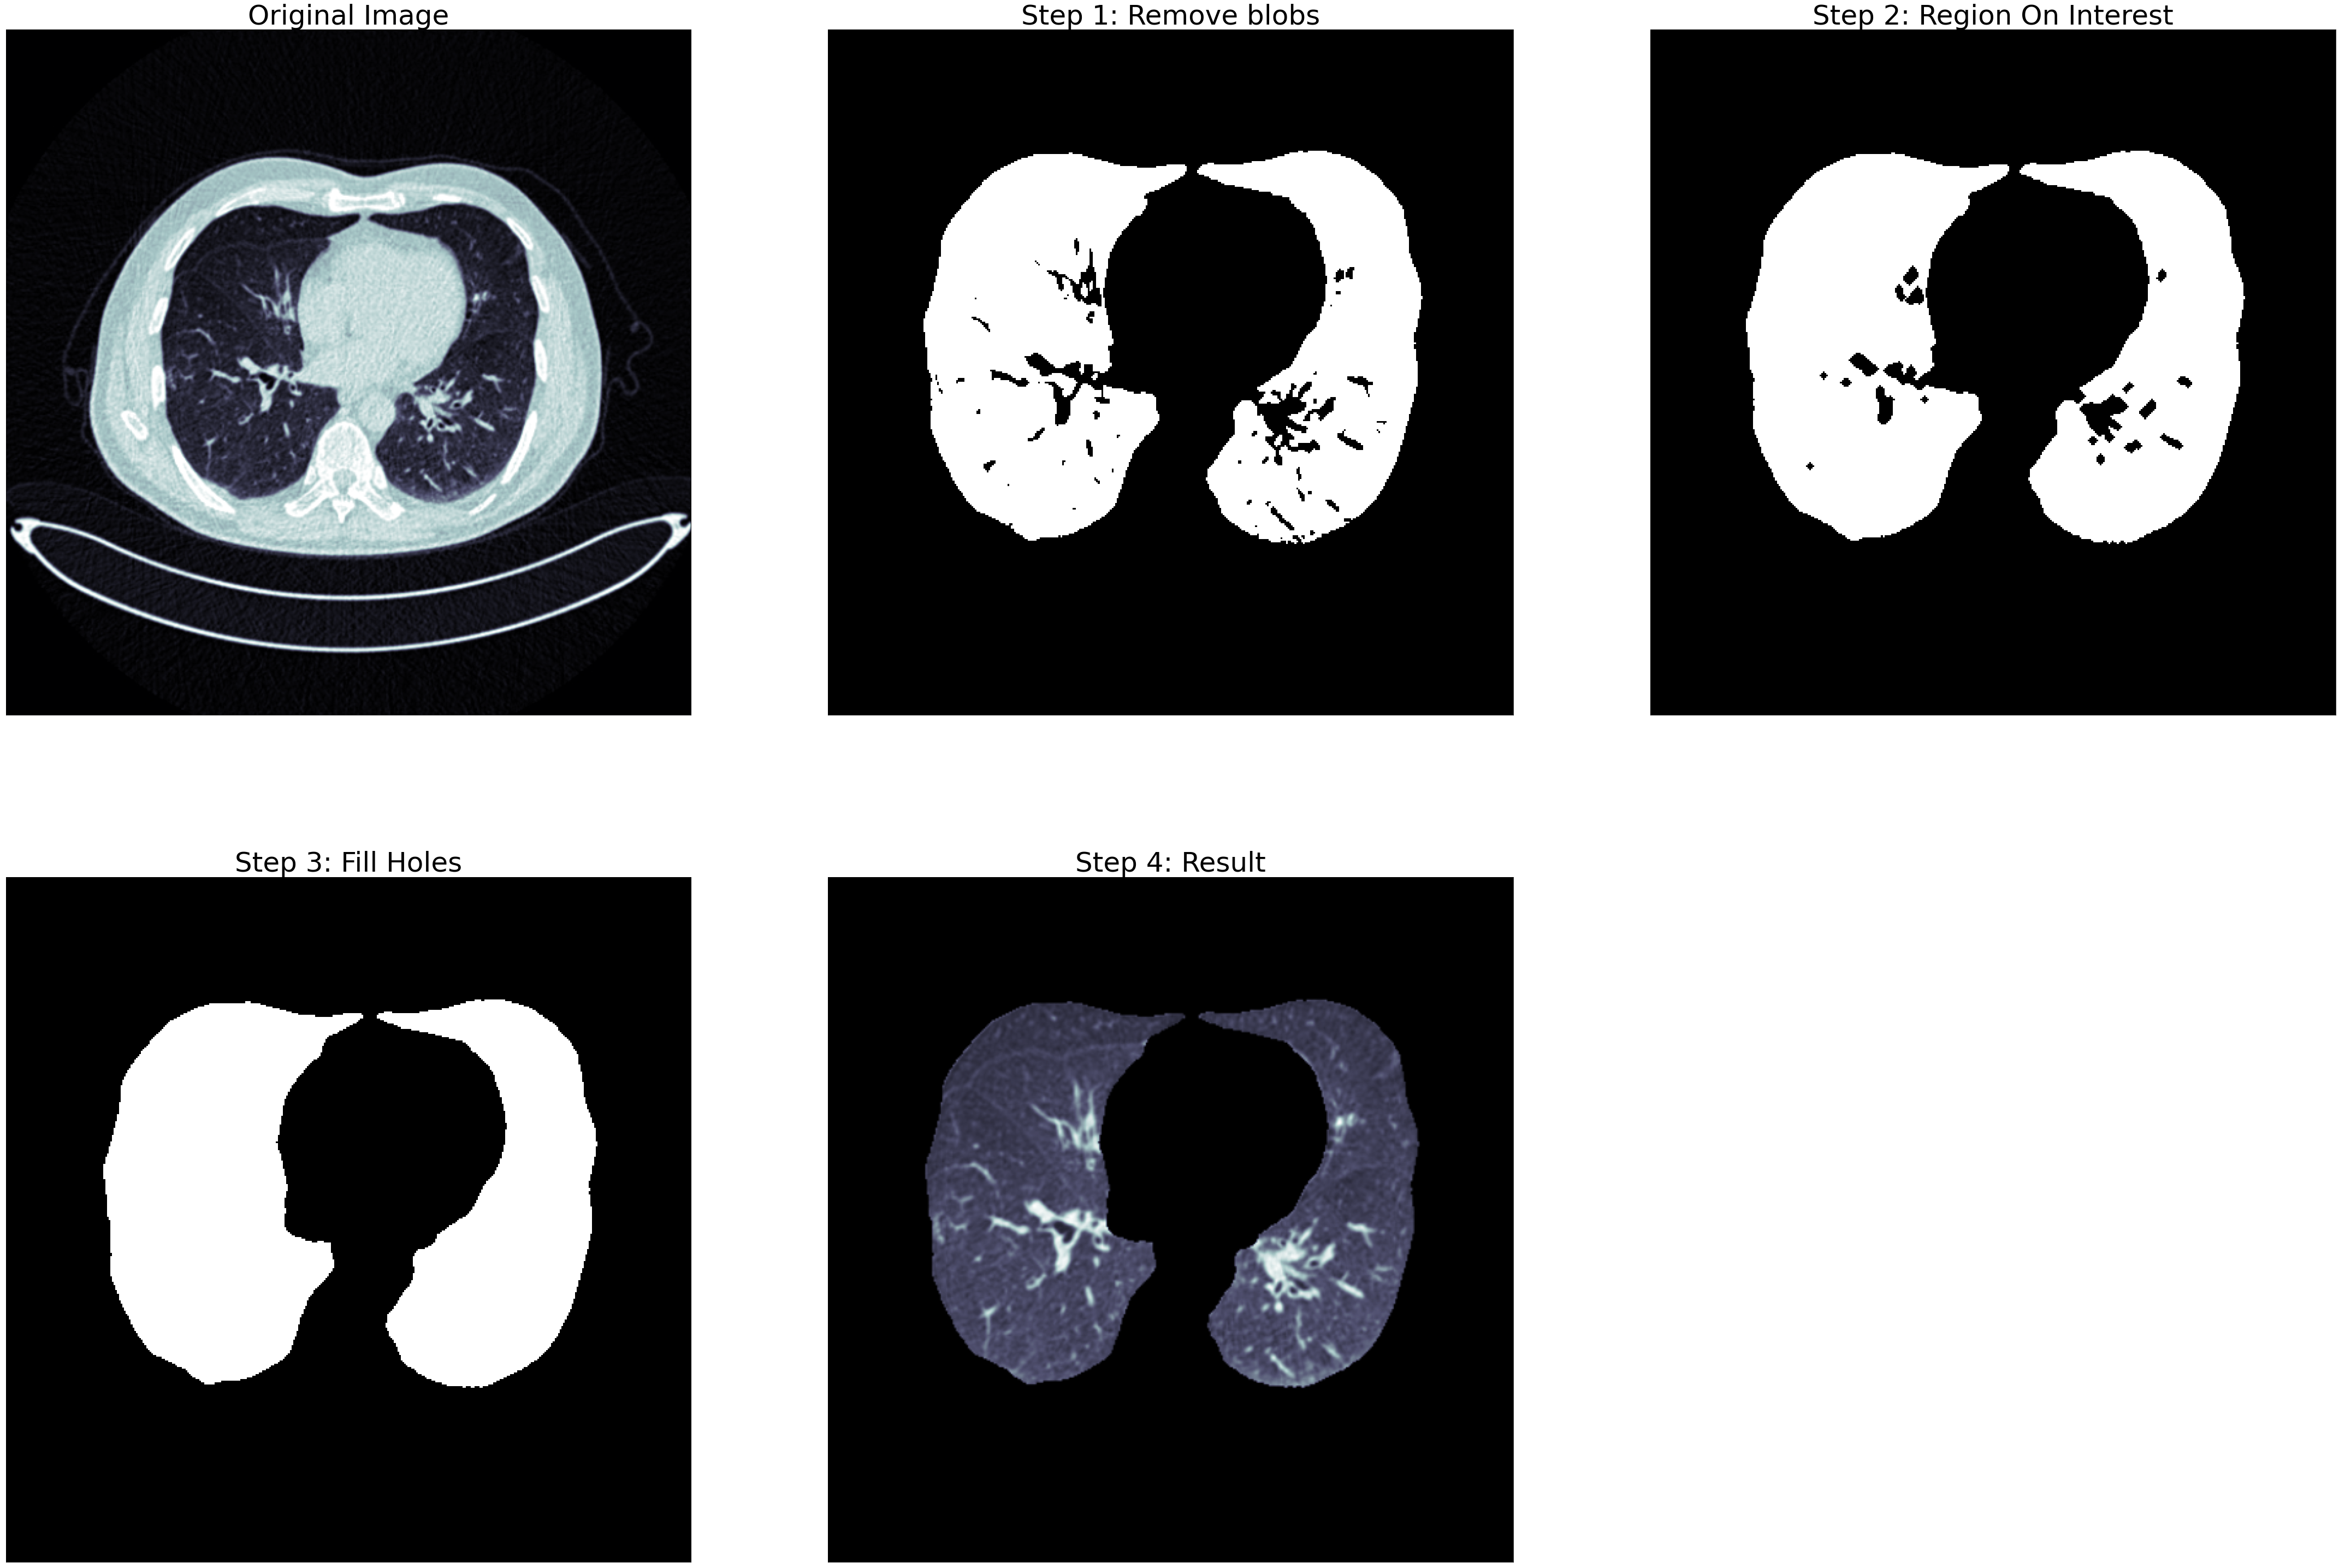

In [12]:
numOfImg = 1
test = X[numOfImg].copy()
get_segmented_lungs(test, numOfImg, plot = True, show_on_window=True, crop_percentage=0.12)


In [14]:
#Apply to all images
X_segmented = np.empty((len(img_list), IMG_SIZE, IMG_SIZE), dtype=np.uint8)

for i, img in enumerate(X):
    im = img.copy()
    X_segmented[i] = get_segmented_lungs(im, i)

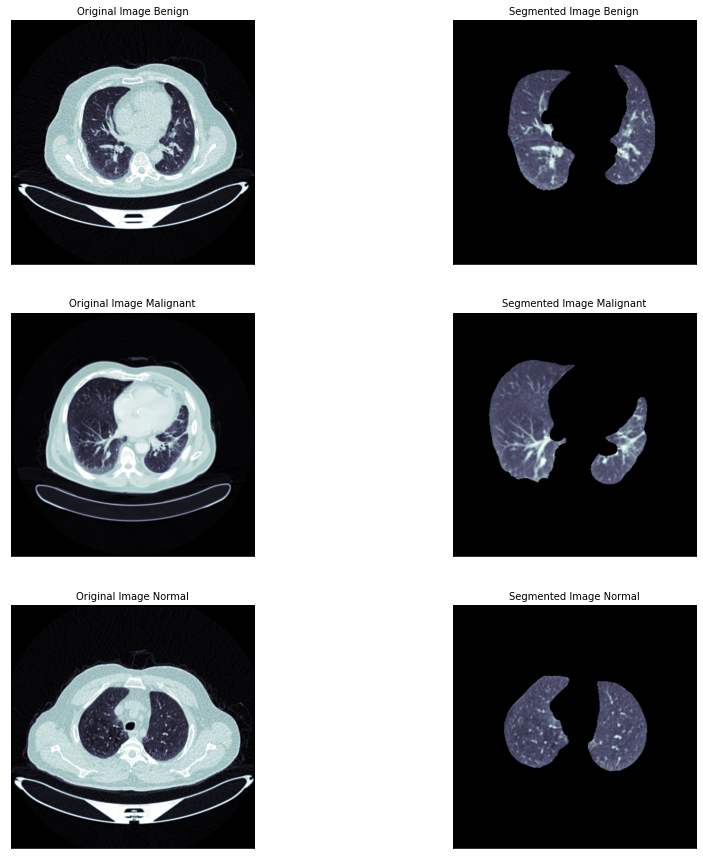

In [15]:
#show the changes of images
images = [X[0], X_segmented[0],
          X[100], X_segmented[100],
          X[200], X_segmented[200]]
titles = ['Original Image ' + y[0], 'Segmented Image ' + y[0], 
         'Original Image ' + y[100], 'Segmented Image ' + y[100], 
         'Original Image ' + y[200], 'Segmented Image ' + y[200]]
plot_img(images, titles, camp=plt.cm.bone, rows = 3, cols = 2, fontsize=10, top=3, right=2)

### 2.0 Only remain the nodules of the lung

In [8]:
#define function to get the nodules
def get_nodules_lungs(im, plot=False):
    
    #Step 1: Get Nodules in binary
    binary = im < 140
    
    get_high_vals = binary == 0
    
    nodules = im.copy()
    
    nodules[nodules < 140] = 0
    
    if plot == True:
        images = [im, binary, nodules]
        titles = ['Segmented Image', 'Binary Nodules Image', 'Nodules Image']
        plot_img(images, titles, rows = 1, cols = 3, fontsize= 10)
        
    return nodules

#### Plot a image to show before and after result

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

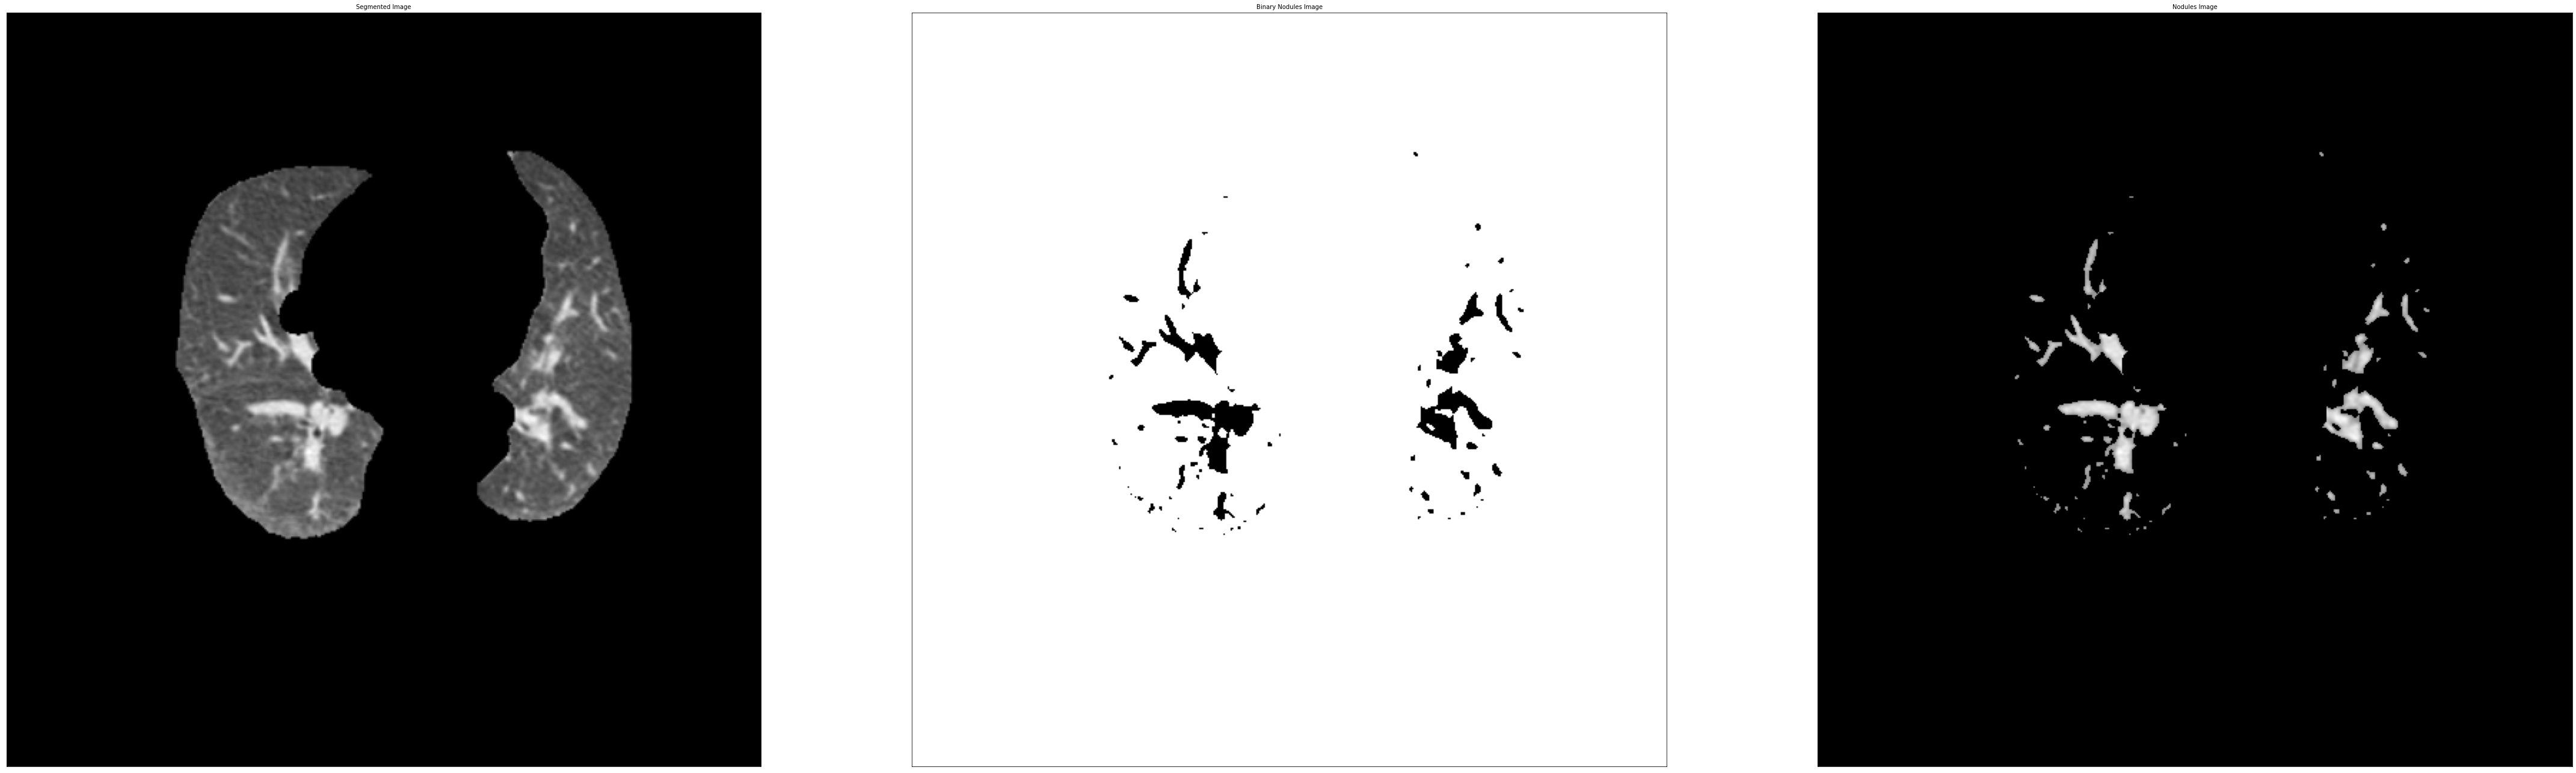

In [12]:
test = X_segmented[0].copy()
get_nodules_lungs(test, True)

#### Convert all segmented image to nodules images

In [9]:
X_nodules = np.empty((len(img_list), IMG_SIZE, IMG_SIZE), dtype=np.uint8)

for i, img in enumerate(X_segmented):
    im = img.copy()
    X_nodules[i] = get_nodules_lungs(im)

#### show the changes of lung image from CT-Scan to segmented lung to Nodules

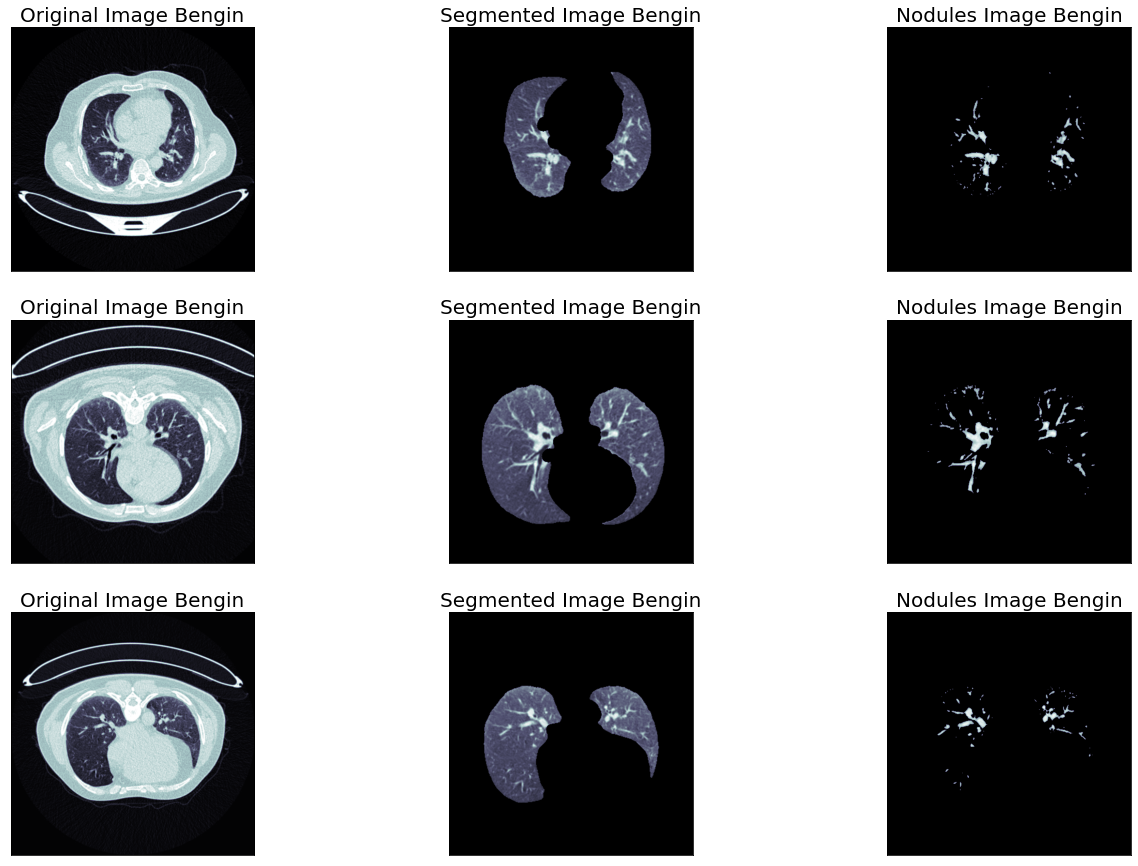

In [14]:
images = [X[0], X_segmented[0], X_nodules[0],
          X[24], X_segmented[24], X_nodules[24],
          X[48], X_segmented[48], X_nodules[48]]
titles = ['Original Image ' + y[0], 'Segmented Image ' + y[0], 'Nodules Image ' + y[0],
         'Original Image ' + y[24], 'Segmented Image ' + y[24], 'Nodules Image ' + y[24], 
         'Original Image ' + y[48], 'Segmented Image ' + y[48], 'Nodules Image ' + y[48]]
plot_img(images, titles, camp=plt.cm.bone, rows = 3, cols = 3, fontsize= 20, top=3, right=3)

#### After filtering, there are still lot of noise because of blood vessels. Thus we further remove the two largest connected component.
Two method to do:
1. Remove based on the region properties
2. Using Opening method to remove

In [10]:
# method 1: Remove based on the region properties
selem = ball(2)
binary = binary_closing(X_nodules, selem)

X_nodules_further = X_nodules.copy()

label_scan = label(binary)

areas = [r.area for r in regionprops(label_scan)]
areas.sort()

for r in regionprops(label_scan):
    max_x, max_y, max_z = 0, 0, 0
    min_x, min_y, min_z = 2000, 2000, 2000
    
    for c in r.coords:
        max_z = max(c[0], max_z)
        max_y = max(c[1], max_y)
        max_x = max(c[2], max_x)
        
        min_z = min(c[0], min_z)
        min_y = min(c[1], min_y)
        min_x = min(c[2], min_x)
    if (min_z == max_z or min_y == max_y or min_x == max_x or r.area > areas[-3]):
        for c in r.coords:
            X_nodules_further[c[0], c[1], c[2]] = 0
    else:
        index = (max((max_x - min_x), (max_y - min_y), (max_z - min_z))) / (min((max_x - min_x), (max_y - min_y) , (max_z - min_z)))

In [11]:
# method 2: Using Opening method to remove
selem = ball(2)
X_nodules_opening = binary_closing(X_nodules, selem)

#### Different between method 1 and method 2

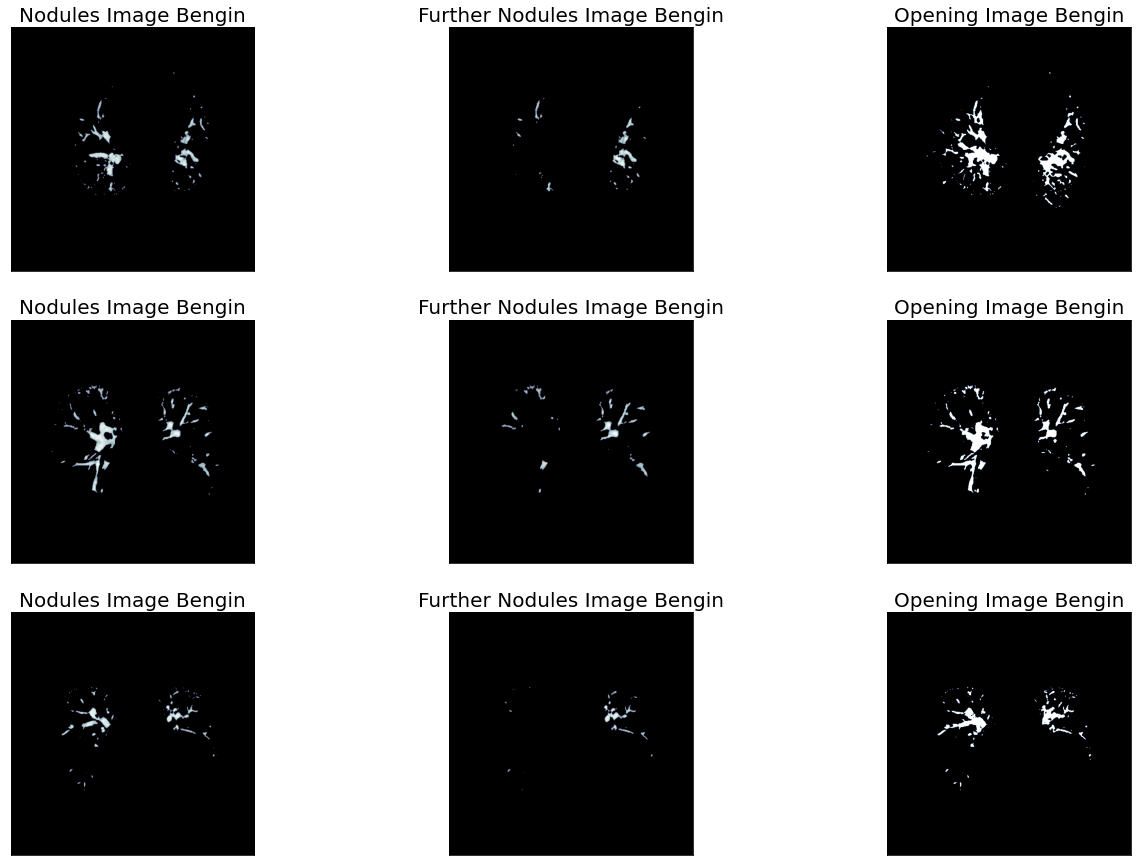

In [18]:
images = [X_nodules[0], X_nodules_further[0], X_nodules_opening[0],
          X_nodules[24], X_nodules_further[24], X_nodules_opening[24],
          X_nodules[48], X_nodules_further[48], X_nodules_opening[48]]
titles = ['Nodules Image ' + y[0], 'Further Nodules Image ' + y[0], 'Opening Image ' + y[0],
         'Nodules Image ' + y[24],  'Further Nodules Image ' + y[24], 'Opening Image ' + y[24],
         'Nodules Image ' + y[48], 'Further Nodules Image ' + y[48], 'Opening Image ' + y[48]]
plot_img(images, titles, camp=plt.cm.bone, rows = 3, cols = 3, fontsize= 20, top=3, right=3)

#### Method 1 still remail a lot of feature and remove a bit noise from the image, while method 2 remove a lot of feature, so we use method 1 to continue since it provide more useful information for us

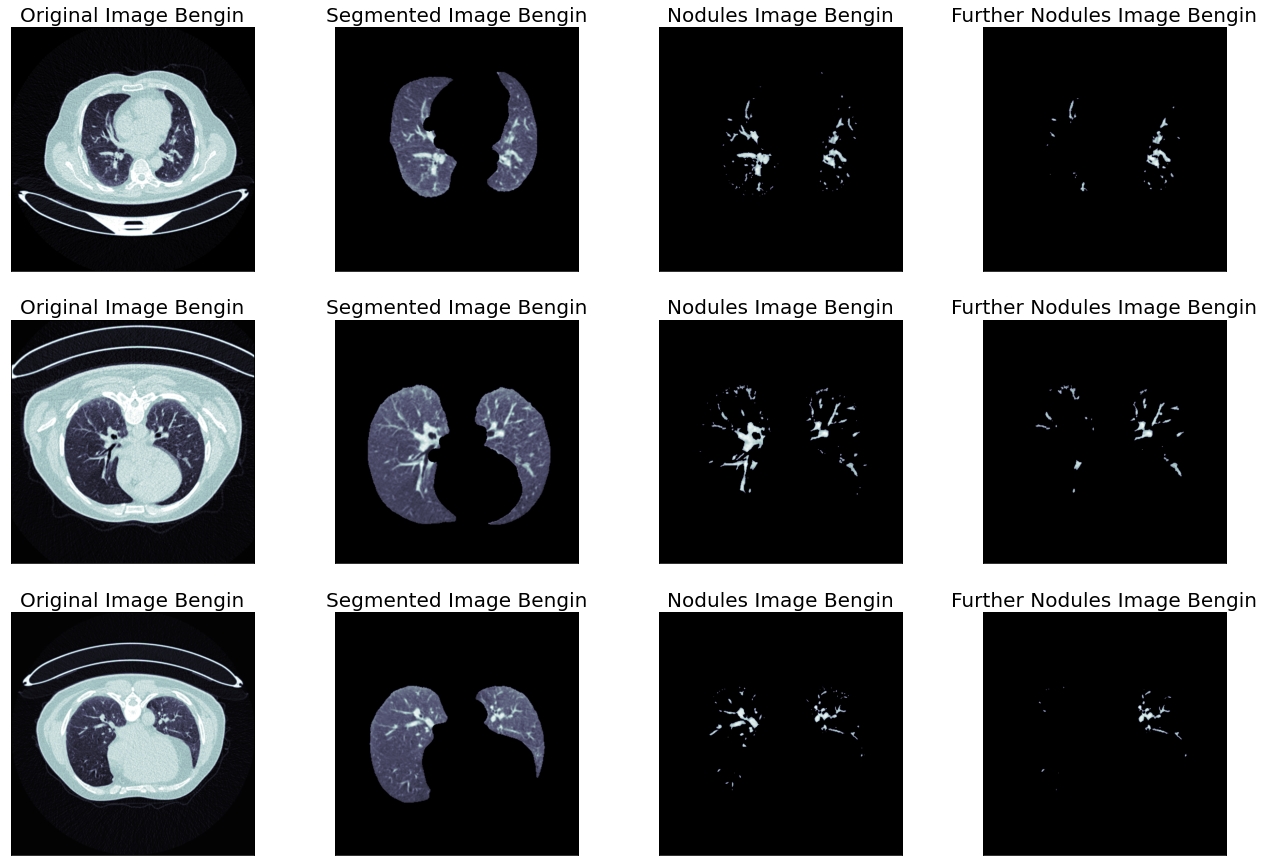

In [19]:
images = [X[0], X_segmented[0], X_nodules[0], X_nodules_further[0], 
          X[24], X_segmented[24], X_nodules[24], X_nodules_further[24], 
          X[48], X_segmented[48], X_nodules[48], X_nodules_further[48]]
titles = ['Original Image ' + y[0], 'Segmented Image ' + y[0], 'Nodules Image ' + y[0], 'Further Nodules Image ' + y[0],
         'Original Image ' + y[24], 'Segmented Image ' + y[24], 'Nodules Image ' + y[24],  'Further Nodules Image ' + y[24],
         'Original Image ' + y[48], 'Segmented Image ' + y[48], 'Nodules Image ' + y[48], 'Further Nodules Image ' + y[48]]
plot_img(images, titles, camp=plt.cm.bone, rows = 3, cols = 4, fontsize= 20, top=3, right=3)

In [17]:
#flip vertically
directory1 = 'preprocessing/pre2/'
directory2 = '.jpg'
titles = ['segmented', 'nodules', 'further_filter']
images = [X_segmented, X_nodules, X_nodules_further]

for i in range(1385):
    for n in range(3):
        filename = directory1 + str(n+1) + titles[n] + '/' + y[i] + '_' + titles[n] + '(' + str(i+1) + ')' + directory2
        cv.imwrite(filename, images[n][i])

## 3d plot

In [12]:
def plot_3d(images, title, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = images.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces, normals, values = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title)
    
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

#### Seperate the class to plot each class 3D visual

In [21]:
Bengin = np.empty((30, IMG_SIZE, IMG_SIZE), dtype=np.uint8)
Malignant = np.empty((30, IMG_SIZE, IMG_SIZE), dtype=np.uint8)
Normal = np.empty((30, IMG_SIZE, IMG_SIZE), dtype=np.uint8)
iBengin = 0
iMalignant = 0
iNormal = 0

for i, img in enumerate(X_nodules):
    im = img.copy()
    if(y[i] == 'Bengin' and iBengin < 30):
        Bengin[iBengin] = im
        iBengin+=1
    elif(y[i] == 'Malignant' and iMalignant < 30):
        Malignant[iMalignant] = im
        iMalignant+=1
    elif(y[i] == 'Normal' and iNormal < 30):
        Normal[iNormal] = im
        iNormal+=1

#### Plot Bengin 3D Visualization

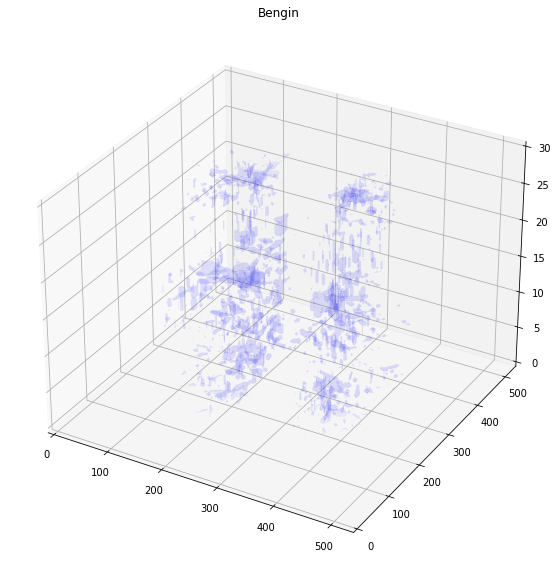

In [22]:
#Plot Bengin 3D Visualization
plot_3d(Bengin, 'Bengin', 150)

#### Plot Malignant 3D Visualization

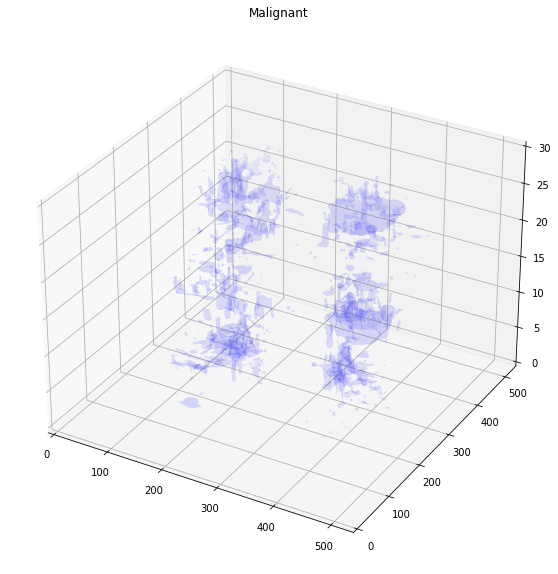

In [23]:
#Plot Malignant 3D Visualization
plot_3d(Malignant, 'Malignant', 150)

#### Plot Normal 3D Visualization

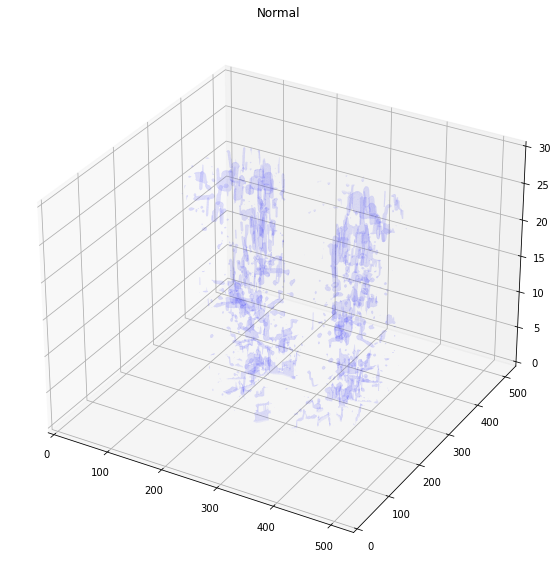

In [24]:
#Plot Bengin 3D Visualization
plot_3d(Normal, 'Normal', 150)

# 3.0 Classification
## 3.1 Save Data

In [23]:
directory1 = 'dataset/after_preprocessing/'
directory2 = ['test/', 'train/', 'full/']
directory3 = '.jpg'
titles = ['Bengin', 'Malignant', 'Normal']
direc2 = 0
num_of_title = 0
filename = ''

for n, img in enumerate(X_segmented):
    if n == 300:
        direc2 = 1
    if y[n] == titles[0]:
        num_of_title = 0
    elif y[n] == titles[1]:
        num_of_title = 1
    else:
        num_of_title = 2
        
    filename = directory1 + directory2[direc2] + 'train_test/'+ titles[num_of_title] + '/' + titles[num_of_title] + '(' + str(n+1) + ')' + directory3
    cv.imwrite(filename, img)
    
    filename = directory1 + directory2[2]+ titles[num_of_title] + '/' + titles[num_of_title] + '(' + str(n+1) + ')' + directory3
    cv.imwrite(filename, img)

NameError: name 'X_segmented' is not defined

## 3.2 Read Data

In [2]:
#get all classes names
classes_old = ["Bengin","Malignant","Normal"]
classes = ["Benign","Malignant","Normal"]

#get all images location(total 1097 img)
img_list = sorted(glob.glob('dataset/after_preprocessing/train_test/*/*/*.*'))
print('Total: ', len(img_list))

#Define variable to hold X & y
#create numpy array placeholder for pixels with 1 channel(grayscale)
IMG_SIZE = 528
CHANNEL = 1
#arg: (length of numpy set, height, width, color channel)
X_segmented = np.empty((len(img_list), IMG_SIZE, IMG_SIZE), dtype=np.uint8)

y = []

# convert images to numpy arrays
for i, img_path in enumerate(img_list):
    # load image
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (IMG_SIZE, IMG_SIZE))
    X_segmented[i] = img
    y.append(classes[0]) if img_path.find(classes_old[0]) != -1 else (y.append(classes[1]) if img_path.find(classes_old[1]) != -1 else y.append(classes_old[2]))
    
y = pd.Series(y)

Total:  1385


## 3.3 Separate into training and testing data

In [3]:
IMG_SIZE = 128
X_dl_segmented_resize = np.empty((len(img_list), IMG_SIZE, IMG_SIZE), dtype=np.uint8)
# X_dl_nodules_resize = np.empty((len(img_list), IMG_SIZE, IMG_SIZE), dtype=np.uint8)
# X_dl_nodules_further_resize = np.empty((len(img_list), IMG_SIZE, IMG_SIZE), dtype=np.uint8)

for i, img in enumerate(X_segmented):
    X_dl_segmented_resize[i] = cv.resize(img, (IMG_SIZE, IMG_SIZE))
    
# for i, img in enumerate(X_nodules):
#     X_nodules_resize[i] = cv.resize(img, (IMG_SIZE, IMG_SIZE))
    
# for i, img in enumerate(X_nodules_further):
#     X_nodules_further_resize[i] = cv.resize(img, (IMG_SIZE, IMG_SIZE))

# convert to 3d array
X_dl_segmented_resize = X_dl_segmented_resize.reshape(-1, IMG_SIZE, IMG_SIZE, CHANNEL)
# X_dl_nodules_resize = X_nodules_resize.reshape(-1, IMG_SIZE, IMG_SIZE, CHANNEL)
# X_dl_nodules_further_resize = X_nodules_further_resize.reshape(-1, IMG_SIZE, IMG_SIZE, CHANNEL)

# convert to 2d array
X_ml_segmented_resize = X_dl_segmented_resize.reshape(X_dl_segmented_resize.shape[0], -1)

# #randomizedSearchCV Dataset
# X_rscv_segmented = X_segmented.reshape(X_segmented.shape[0], -1)

In [4]:
#split into train and test and factorize the label
X_dl_train_segmented = X_dl_segmented_resize[300:1385]
X_dl_test_segmented = X_dl_segmented_resize[0:300]

X_ml_train_segmented = X_ml_segmented_resize[300:1385]
X_ml_test_segmented = X_ml_segmented_resize[0:300]

# X_train_nodules = X_nodules_resize[300:1385]
# X_test_nodules = X_nodules_resize[0:300]
# X_train_nodules_further = X_nodules_further_resize[300:1385]
# X_test_nodules_further = X_nodules_further_resize[0:300]

y_train = y[300:1385]
y_test = y[0:300]
r_rscv = y.copy()

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)
y_rscv = pd.Series(r_rscv)

y_train = y_train.factorize()
y_test = y_test.factorize()
y_rscv = r_rscv.factorize()

xtr_dl, xts_dl, ytr_dl, yts_dl = train_test_split(X_dl_segmented_resize, y_rscv[0], test_size=math.floor(len(X_dl_segmented_resize)*0.2167), 
                                               random_state = np.random.randint(1,1000, 1)[0])
xtr_ml, xts_ml, ytr_ml, yts_ml = train_test_split(X_ml_segmented_resize, y_rscv[0], test_size=math.floor(len(X_ml_segmented_resize)*0.2167), 
                                               random_state = np.random.randint(1,1000, 1)[0])

In [5]:
X_dl_segmented_resize.shape

(1385, 128, 128, 1)

#### define a function to print the classification report and confusion matrix

In [6]:
# define a function to print the classification report and confusion matrix
def classification_CM_report(y_test, y_pred, labels, title):
    print(classification_report(y_test, y_pred, target_names=labels))
    
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=labels), 
                      columns=labels, index=labels)

    plt.figure(figsize = (15,8))
    plt.title(title, fontsize = 25)

    sns.set_context('talk')
    ax = sns.heatmap(cm, annot=True,fmt='d',xticklabels=True,yticklabels=True)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_ylabel('Actual Data')
    ax.set_xlabel('Predict Data')

#### Define a function called kfold_cv to perform the k-fold cross validation

In [7]:
#Define a function called kfold_cv to perform the k-fold cross validation
def cal_print_accuracy_crossValidate(model, X, y, title, cv=5):
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    modelScores = cross_val_score(model, X, y, cv=cv)
    print("Accuracy with cross validation")
    print('Mean and Standard Deviation of %s classifier on test set: %.4f, %.4f'
         %(title, modelScores.mean() ,modelScores.std()*2))

##### Define a function called get_callback to get the callback function
credit to TensorFlow:https://www.tensorflow.org/tutorials/keras/save_and_load

In [30]:
# Set callback functions to early stop training and save the best model so far
def get_callback(path, patience=10):
    return [EarlyStopping(monitor='val_loss', patience=patience),
                 ModelCheckpoint(filepath=path, monitor='val_loss', save_best_only=True)]

In [31]:
#define a function to convert the y_pred, y_test to human readable (from 0,1,2... to inclusion, pitted....)
def convertLabels(y_test, classes):
    return classes[y_test]

## 3.2 Segmented_Lung_Image
### 3.2.1 DeepLearning
#### 3.2.1.1 CNN
##### Define CNN Model with 4 convolutional layer

In [9]:
# Define CNN Model

cnn = models.Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, CHANNEL)),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        #dense network
        #CNN middle layer no need to specify the shape because the network can figure it out automatically
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(16, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])

cnn.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [10]:
callbacks = get_callback('best_model/best_model_cnn_segmented.h5')

#Train CNN
history_cnn_segmented = cnn.fit(xtr_dl,
                      ytr_dl,
                      callbacks=callbacks,
                      epochs=100,
                      validation_data=(xts_dl, yts_dl))

Epoch 1/100
34/34 [==============================] - 12s 337ms/step - loss: 1.4944 - accuracy: 0.3742 - val_loss: 1.0061 - val_accuracy: 0.4700
Epoch 2/100
34/34 [==============================] - 10s 307ms/step - loss: 0.9969 - accuracy: 0.4986 - val_loss: 0.9073 - val_accuracy: 0.5733
Epoch 3/100
34/34 [==============================] - 10s 297ms/step - loss: 0.8077 - accuracy: 0.6258 - val_loss: 0.7703 - val_accuracy: 0.6667
Epoch 4/100
34/34 [==============================] - 10s 303ms/step - loss: 0.6918 - accuracy: 0.7171 - val_loss: 0.6313 - val_accuracy: 0.7333
Epoch 5/100
34/34 [==============================] - 10s 289ms/step - loss: 0.5338 - accuracy: 0.8009 - val_loss: 0.5825 - val_accuracy: 0.7933
Epoch 6/100
34/34 [==============================] - 10s 293ms/step - loss: 0.4539 - accuracy: 0.8295 - val_loss: 0.4072 - val_accuracy: 0.8367
Epoch 7/100
34/34 [==============================] - 10s 299ms/step - loss: 0.3690 - accuracy: 0.8654 - val_loss: 0.5161 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


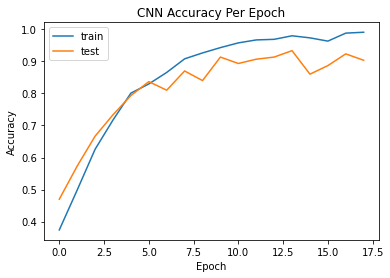

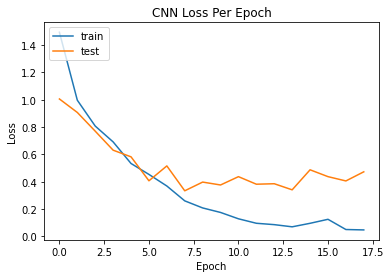

In [11]:
# list all data in history
print(history_cnn_segmented.history.keys())
# summarize history for accuracy
plt.plot(history_cnn_segmented.history['accuracy'])
plt.plot(history_cnn_segmented.history['val_accuracy'])
plt.title('CNN Accuracy Per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_cnn_segmented.history['loss'])
plt.plot(history_cnn_segmented.history['val_loss'])
plt.title('CNN Loss Per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Define CNN Model with 3 convolutional layer

In [28]:
# Define CNN Model

cnn2 = models.Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, CHANNEL)),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        #dense network
        #CNN middle layer no need to specify the shape because the network can figure it out automatically
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])

cnn2.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [29]:
callbacks = get_callback('best_model/best_model_cnn_segmented2.h5')

#Train CNN
history_cnn_segmented = cnn2.fit(xtr_dl,
                      ytr_dl,
                      callbacks=callbacks,
                      epochs=100,
                      validation_data=(xts_dl, yts_dl))

Epoch 1/100
34/34 [==============================] - 10s 295ms/step - loss: 1.5711 - accuracy: 0.4470 - val_loss: 0.9478 - val_accuracy: 0.5333
Epoch 2/100
34/34 [==============================] - 9s 278ms/step - loss: 0.9177 - accuracy: 0.5825 - val_loss: 0.8037 - val_accuracy: 0.6500
Epoch 3/100
34/34 [==============================] - 10s 288ms/step - loss: 0.7116 - accuracy: 0.6949 - val_loss: 0.6091 - val_accuracy: 0.7267
Epoch 4/100
34/34 [==============================] - 9s 272ms/step - loss: 0.4899 - accuracy: 0.8046 - val_loss: 0.4511 - val_accuracy: 0.8033
Epoch 5/100
34/34 [==============================] - 9s 273ms/step - loss: 0.3756 - accuracy: 0.8433 - val_loss: 0.3515 - val_accuracy: 0.8500
Epoch 6/100
34/34 [==============================] - 9s 279ms/step - loss: 0.2847 - accuracy: 0.8876 - val_loss: 0.3093 - val_accuracy: 0.8633
Epoch 7/100
34/34 [==============================] - 10s 281ms/step - loss: 0.2108 - accuracy: 0.9253 - val_loss: 0.2971 - val_accuracy: 0.8

#### 3.2.1.3 Visualization of ANN and CNN epoch performance
##### CNN

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


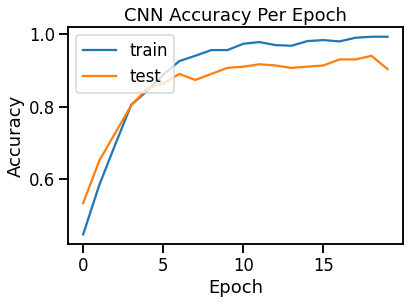

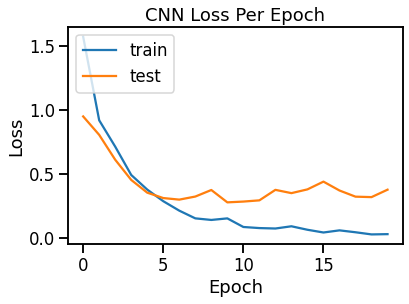

In [30]:
# list all data in history
print(history_cnn_segmented.history.keys())
# summarize history for accuracy
plt.plot(history_cnn_segmented.history['accuracy'])
plt.plot(history_cnn_segmented.history['val_accuracy'])
plt.title('CNN Accuracy Per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_cnn_segmented.history['loss'])
plt.plot(history_cnn_segmented.history['val_loss'])
plt.title('CNN Loss Per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 3.2.1.4 Classification report and Confusion Matrix
##### Classification report and Confusion matrix for CNN with 4 Convolutional layer

##### Test Data

              precision    recall  f1-score   support

      Benign       0.91      0.69      0.78        87
   Malignant       0.88      0.99      0.93       128
      Normal       0.82      0.87      0.85        85

    accuracy                           0.87       300
   macro avg       0.87      0.85      0.85       300
weighted avg       0.87      0.87      0.87       300



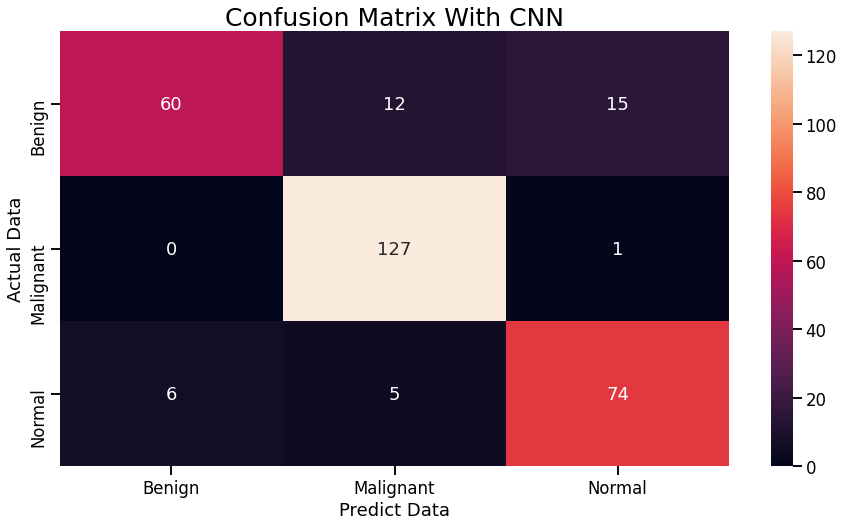

In [34]:
# Read the best model, including its weights and the optimizer
cnn_segmented = tf.keras.models.load_model('best_model/best_model_cnn_segmented.h5')

# Show the model architecture
#cnn_segmented.summary()

y_pred_cnn_segmented = cnn_segmented.predict(xts_dl)
#result is in float format, so using argmax to convert it to int
y_pred_cnn_segmented = [np.argmax(element) for element in y_pred_cnn_segmented]

#y_test
y_test_converted = [convertLabels(element, classes) for element in  yts_dl]
#y_pred
y_pred_cnn_converted = [convertLabels(element, classes) for element in y_pred_cnn_segmented]
classification_CM_report(y_test_converted, y_pred_cnn_converted, classes, "Confusion Matrix With CNN")

##### Train Data

              precision    recall  f1-score   support

      Benign       0.99      0.86      0.92       321
   Malignant       0.97      1.00      0.98       433
      Normal       0.90      0.98      0.94       331

    accuracy                           0.95      1085
   macro avg       0.95      0.95      0.95      1085
weighted avg       0.96      0.95      0.95      1085



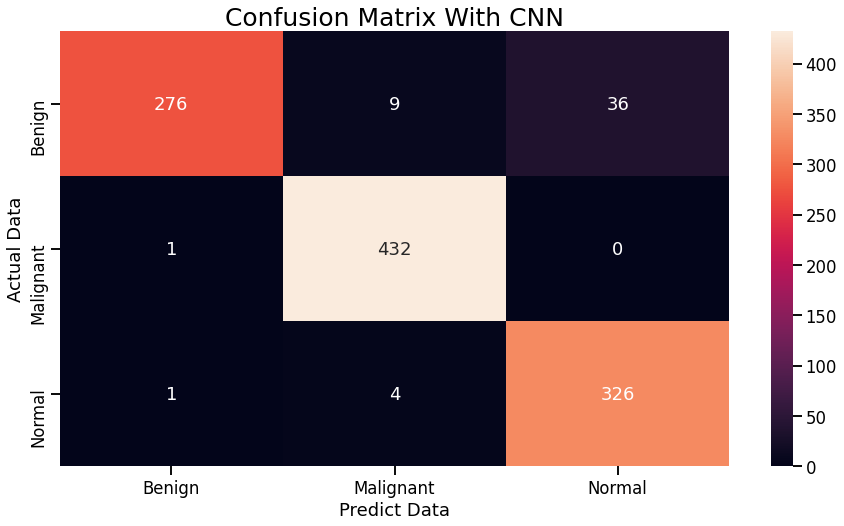

In [35]:
# Read the best model, including its weights and the optimizer
cnn_segmented = tf.keras.models.load_model('best_model/best_model_cnn_segmented.h5')

# Show the model architecture
#cnn_segmented.summary()

y_pred_cnn_segmented = cnn_segmented.predict(xtr_dl)
#result is in float format, so using argmax to convert it to int
y_pred_cnn_segmented = [np.argmax(element) for element in y_pred_cnn_segmented]

#y_test
y_test_converted = [convertLabels(element, classes) for element in  ytr_dl]
#y_pred
y_pred_cnn_converted = [convertLabels(element, classes) for element in y_pred_cnn_segmented]
classification_CM_report(y_test_converted, y_pred_cnn_converted, classes, "Confusion Matrix With CNN")

##### Classification report and Confusion matrix for CNN with 3 Convolutional layer

##### Test Data

              precision    recall  f1-score   support

      Benign       0.96      0.77      0.85        87
   Malignant       0.93      0.98      0.96       128
      Normal       0.83      0.93      0.88        85

    accuracy                           0.91       300
   macro avg       0.91      0.89      0.90       300
weighted avg       0.91      0.91      0.91       300



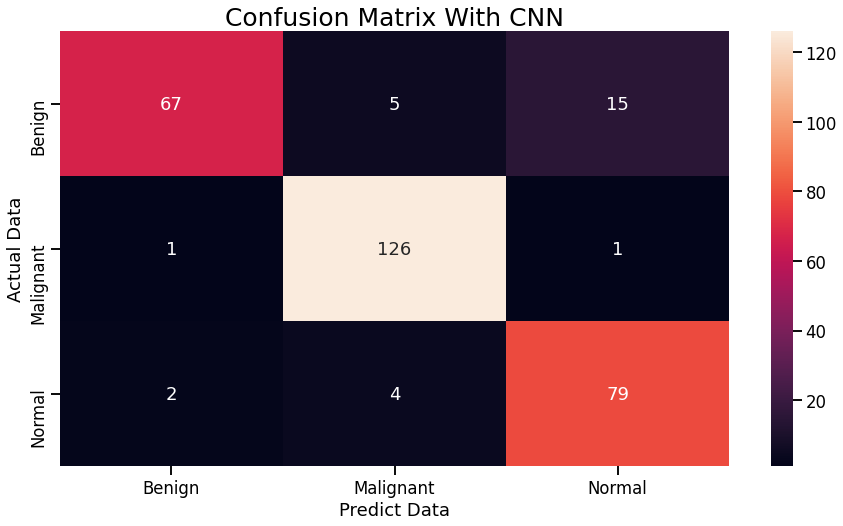

In [36]:
# Read the best model, including its weights and the optimizer
cnn_segmented = tf.keras.models.load_model('best_model/best_model_cnn_segmented2.h5')

# Show the model architecture
#cnn_segmented.summary()

y_pred_cnn_segmented = cnn_segmented.predict(xts_dl)
#result is in float format, so using argmax to convert it to int
y_pred_cnn_segmented = [np.argmax(element) for element in y_pred_cnn_segmented]

#y_test
y_test_converted = [convertLabels(element, classes) for element in yts_dl]
#y_pred
y_pred_cnn_converted = [convertLabels(element, classes) for element in y_pred_cnn_segmented]
classification_CM_report(y_test_converted, y_pred_cnn_converted, classes, "Confusion Matrix With CNN")

##### Train Data

              precision    recall  f1-score   support

      Benign       1.00      0.96      0.98       321
   Malignant       0.99      1.00      0.99       433
      Normal       0.98      1.00      0.99       331

    accuracy                           0.99      1085
   macro avg       0.99      0.99      0.99      1085
weighted avg       0.99      0.99      0.99      1085



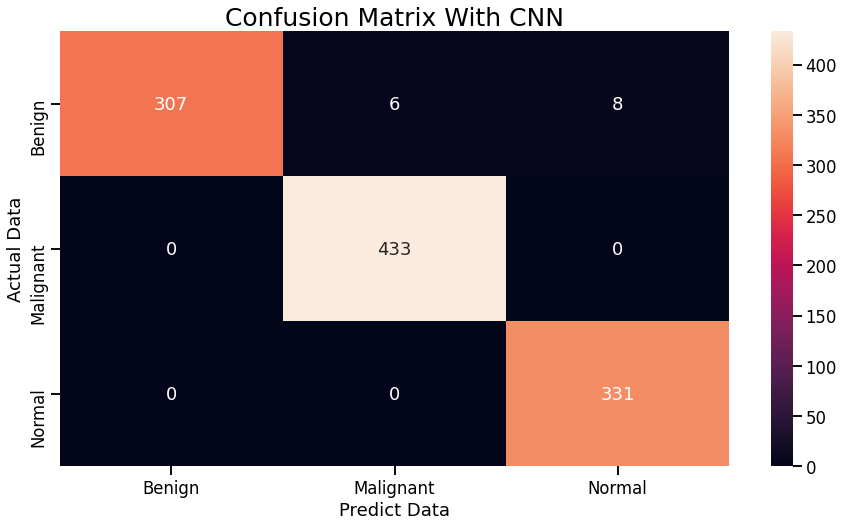

In [37]:
# Read the best model, including its weights and the optimizer
cnn_segmented = tf.keras.models.load_model('best_model/best_model_cnn_segmented2.h5')

# Show the model architecture
#cnn_segmented.summary()

y_pred_cnn_segmented = cnn_segmented.predict(xtr_dl)
#result is in float format, so using argmax to convert it to int
y_pred_cnn_segmented = [np.argmax(element) for element in y_pred_cnn_segmented]

#y_test
y_test_converted = [convertLabels(element, classes) for element in  ytr_dl]
#y_pred
y_pred_cnn_converted = [convertLabels(element, classes) for element in y_pred_cnn_segmented]
classification_CM_report(y_test_converted, y_pred_cnn_converted, classes, "Confusion Matrix With CNN")

# 5-fold cross

In [61]:
math.floor(len(X_dl_segmented_resize)*0.2167)

300

##### cnn with 3 convolutional layer

In [128]:
def cnn_model():
    # Define CNN Model

    cnn = models.Sequential([
            layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, CHANNEL)),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            #dense network
            #CNN middle layer no need to specify the shape because the network can figure it out automatically
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(16, activation='relu'),
            layers.Dense(3, activation='softmax')
        ])

    cnn.compile(optimizer='adam',
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
    
    return cnn

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS, model, callbacks):
    results = model.fit(t_x, t_y, callbacks=callbacks, epochs=100, verbose=1, validation_data=(val_x, val_y))
    model = tf.keras.models.load_model('best_model/best_model_cnn_segmented_cv5.h5')
    print("Val Score: ", model.evaluate(val_x, val_y))
    return model.evaluate(val_x, val_y)

n_folds=5
epochs=8

model_history = []
means_test = 0

for i in range(n_folds):
    model = None
    model = cnn_model()
    print("Training on Fold: ",i+1)
    callbacks = get_callback('best_model/best_model_cnn_segmented_cv5.h5')
    t_x, val_x, t_y, val_y = train_test_split(X_dl_segmented_resize, y_rscv[0], test_size=math.floor(len(X_dl_segmented_resize)*0.2167), 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, model, callbacks))
    print("======="*12, end="\n\n\n")
    means_test += model_history[i][1]
    
print("Average Testing Accuracies for CNN with 3 Convolutional Layer = ", means_test / 5)

Training on Fold:  1
Epoch 1/100
34/34 [==============================] - 10s 285ms/step - loss: 1.9136 - accuracy: 0.3760 - val_loss: 1.0078 - val_accuracy: 0.5100
Epoch 2/100
34/34 [==============================] - 10s 281ms/step - loss: 0.9640 - accuracy: 0.5392 - val_loss: 0.8399 - val_accuracy: 0.6800
Epoch 3/100
34/34 [==============================] - 10s 282ms/step - loss: 0.7283 - accuracy: 0.7023 - val_loss: 0.6734 - val_accuracy: 0.7067
Epoch 4/100
34/34 [==============================] - 10s 284ms/step - loss: 0.5495 - accuracy: 0.7825 - val_loss: 0.5331 - val_accuracy: 0.7800
Epoch 5/100
34/34 [==============================] - 10s 281ms/step - loss: 0.3943 - accuracy: 0.8507 - val_loss: 0.3549 - val_accuracy: 0.8733
Epoch 6/100
34/34 [==============================] - 10s 285ms/step - loss: 0.2789 - accuracy: 0.8922 - val_loss: 0.3958 - val_accuracy: 0.8700
Epoch 7/100
34/34 [==============================] - 10s 281ms/step - loss: 0.2184 - accuracy: 0.9253 - val_loss: 0

34/34 [==============================] - 9s 277ms/step - loss: 0.0512 - accuracy: 0.9843 - val_loss: 0.3512 - val_accuracy: 0.9133
Epoch 14/100
34/34 [==============================] - 9s 279ms/step - loss: 0.0546 - accuracy: 0.9806 - val_loss: 0.3254 - val_accuracy: 0.9267
Epoch 15/100
34/34 [==============================] - 9s 277ms/step - loss: 0.0542 - accuracy: 0.9797 - val_loss: 0.3131 - val_accuracy: 0.9100
Epoch 16/100
34/34 [==============================] - 9s 278ms/step - loss: 0.0421 - accuracy: 0.9843 - val_loss: 0.4461 - val_accuracy: 0.8967
Epoch 17/100
34/34 [==============================] - 9s 276ms/step - loss: 0.0629 - accuracy: 0.9834 - val_loss: 0.3480 - val_accuracy: 0.9033
Epoch 18/100
34/34 [==============================] - 9s 276ms/step - loss: 0.0452 - accuracy: 0.9834 - val_loss: 0.3960 - val_accuracy: 0.8900
Epoch 19/100
34/34 [==============================] - 9s 276ms/step - loss: 0.0439 - accuracy: 0.9871 - val_loss: 0.4632 - val_accuracy: 0.8767
Epoch

##### cnn with 4 convolutional layer

In [127]:
def cnn_model():
    # Define CNN Model

    cnn = models.Sequential([
            layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, CHANNEL)),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
        
            layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            #dense network
            #CNN middle layer no need to specify the shape because the network can figure it out automatically
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(16, activation='relu'),
            layers.Dense(3, activation='softmax')
        ])

    cnn.compile(optimizer='adam',
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
    
    return cnn

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS, model, callbacks):
    results = model.fit(t_x, t_y, callbacks=callbacks, epochs=100, verbose=1, validation_data=(val_x, val_y))
    model = tf.keras.models.load_model('best_model/best_model_cnn_segmented_cv5.h5')
    print("Val Score: ", model.evaluate(val_x, val_y))
    return model.evaluate(val_x, val_y)

n_folds=5
epochs=8

model_history = []
means_test = 0

for i in range(n_folds):
    model = None
    model = cnn_model()
    print("Training on Fold: ",i+1)
    callbacks = get_callback('best_model/best_model_cnn_segmented_cv5.h5')
    t_x, val_x, t_y, val_y = train_test_split(X_dl_segmented_resize, y_rscv[0], test_size=math.floor(len(X_dl_segmented_resize)*0.2167), 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, model, callbacks))
    print("======="*12, end="\n\n\n")
    means_test += model_history[i][1]
    
print("Average Testing Accuracies for CNN with 4 Convolutional Layer = ", means_test / 5)

Training on Fold:  1
Epoch 1/100
34/34 [==============================] - 12s 335ms/step - loss: 1.3455 - accuracy: 0.4046 - val_loss: 1.0140 - val_accuracy: 0.4700
Epoch 2/100
34/34 [==============================] - 11s 330ms/step - loss: 0.9513 - accuracy: 0.5382 - val_loss: 0.8576 - val_accuracy: 0.6367
Epoch 3/100
34/34 [==============================] - 11s 328ms/step - loss: 0.7662 - accuracy: 0.6728 - val_loss: 0.6586 - val_accuracy: 0.7367
Epoch 4/100
34/34 [==============================] - 11s 318ms/step - loss: 0.5660 - accuracy: 0.7696 - val_loss: 0.5373 - val_accuracy: 0.7967
Epoch 5/100
34/34 [==============================] - 11s 315ms/step - loss: 0.4826 - accuracy: 0.8120 - val_loss: 0.4986 - val_accuracy: 0.7867
Epoch 6/100
34/34 [==============================] - 10s 304ms/step - loss: 0.3563 - accuracy: 0.8756 - val_loss: 0.3402 - val_accuracy: 0.8667
Epoch 7/100
34/34 [==============================] - 10s 302ms/step - loss: 0.2494 - accuracy: 0.9152 - val_loss: 0

Epoch 33/100
10/10 [==============================] - 1s 54ms/step - loss: 0.1720 - accuracy: 0.9567
Val Score:  [0.17196069657802582, 0.9566666483879089]
10/10 [==============================] - 1s 54ms/step - loss: 0.1720 - accuracy: 0.9567


Training on Fold:  5
Epoch 1/100
34/34 [==============================] - 11s 309ms/step - loss: 1.3929 - accuracy: 0.4175 - val_loss: 0.9384 - val_accuracy: 0.5600
Epoch 2/100
34/34 [==============================] - 10s 305ms/step - loss: 0.9552 - accuracy: 0.5502 - val_loss: 0.7692 - val_accuracy: 0.6333
Epoch 3/100
34/34 [==============================] - 10s 304ms/step - loss: 0.8386 - accuracy: 0.6406 - val_loss: 0.6801 - val_accuracy: 0.7200
Epoch 4/100
34/34 [==============================] - 10s 304ms/step - loss: 0.6409 - accuracy: 0.7253 - val_loss: 0.3606 - val_accuracy: 0.8567
Epoch 5/100
34/34 [==============================] - 10s 306ms/step - loss: 0.4442 - accuracy: 0.8258 - val_loss: 0.2822 - val_accuracy: 0.9133
Epoch 6/100
34

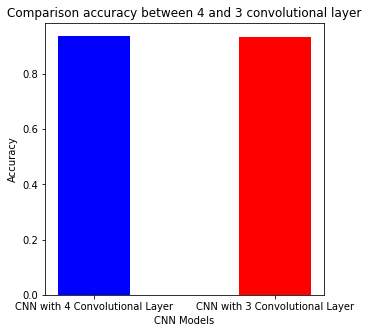

In [21]:
CNN4cl =  0.9379999876022339
CNN3cl =  0.9333333253860474

data = {'CNN with 4 Convolutional Layer':0.9379999876022339, 'CNN with 3 Convolutional Layer':0.9333333253860474}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (5, 5))
 
# creating the bar plot
plt.bar(courses, values, color =['blue','red'], width = 0.4)
 
plt.xlabel("CNN Models")
plt.ylabel("Accuracy")
plt.title("Comparison accuracy between 4 and 3 convolutional layer")
plt.show()

## Cross Validation for RF, LR SVC

In [ ]:
rf = RandomForestClassifier()
cal_print_accuracy_crossValidate(rf, X_ml_train_segmented, y_rscv[0], 'Random Forest Cross Validation 5', cv=5)

In [ ]:
lr = LogisticRegression()
cal_print_accuracy_crossValidate(lr, X_ml_segmented_resize, y_rscv[0], 'Logistic Regression Cross Validation 5', cv=5)

In [ ]:
svm = SVC()
cal_print_accuracy_crossValidate(svm, X_ml_segmented_resize, y_rscv[0], 'Support Vector Machine Cross Validation 5', cv=5)

# Careful

# Careful

# Careful

# Careful

# Careful

# Careful

### 3.2.2 MachineLearning
#### 3.2.2.1 RandomForest
##### Define RandomForest Model

Best Parameter<br>
{'n_estimators': 920,<br>
 'min_samples_split': 2,<br>
 'min_samples_leaf': 2,<br>
 'max_features': 'sqrt',<br>
 'max_depth': 40,<br>
 'bootstrap': True}<br>

In [82]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 6)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
space = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = space, n_iter = 100, cv = 3, verbose=10, scoring='accuracy', random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_ml_segmented_resize, y_rscv[0])
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 920,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': True}

#### 3.2.2.2 LogisticRegression
##### Define LogisticRegression Model
{'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.01}

In [83]:
lr = LogisticRegression()

# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [0.001, 0.01, 0.1, 0.2, 0.5, 0.7, 1, 2, 3, 4, 5, 6, 7]

lr_random = RandomizedSearchCV(estimator = lr, param_distributions = space, n_iter=100, cv = 3, verbose=10, scoring='accuracy', random_state=42, n_jobs = -1)
lr_random.fit(X_ml_segmented_resize, y_rscv[0])
lr_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.01}

#### 3.2.2.3 SVM
##### Define SupportVectorMachine(SVM) Model
{'kernel': 'rbf', 'gamma': 1, 'C': 1}

In [ ]:
svm = SVC()

# defining parameter range
space = {'C': [0.01, 0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'degree' : [1, 2, 3, 4, 5, 6, 7],
              'kernel': ['rbf', 'linear', 'poly']} 

svm_random = RandomizedSearchCV(estimator = svm, param_distributions = space, n_iter=100, cv = 3, verbose=10, scoring='accuracy', random_state=42, n_jobs = -1)
svm_random.fit(X_ml_segmented_resize, y_rscv[0])
svm_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


# Careful

# Careful

# Careful

# Careful

# Careful

# Careful

In [8]:
rf_best_param = RandomForestClassifier(n_estimators = 920,
 min_samples_split = 2,
 min_samples_leaf = 2,
 max_features = 'sqrt',
 max_depth = 40,
 bootstrap = True)
rf_best_param.fit(xtr_ml, ytr_ml)

## Predicting
y_pred_rf_segmented = rf_best_param.predict(xts_ml)
rf_segmented_score = accuracy_score(yts_ml, y_pred_rf_segmented)
print('Random Forest Accuracy: ', rf_segmented_score)

Random Forest Accuracy:  0.9066666666666666


In [9]:
lr_best_param = LogisticRegression(solver = 'newton-cg',
 penalty = 'l2',
 C = 0.01)
lr_best_param.fit(xtr_ml, ytr_ml)

## Predicting
y_pred_lr_segmented = lr_best_param.predict(xts_ml)
lr_segmented_score = accuracy_score(yts_ml, y_pred_lr_segmented)
print('Logistic Regression Accuracy: ', lr_segmented_score)

Logistic Regression Accuracy:  0.8866666666666667


In [37]:
#{'kernel': 'rbf', 'gamma': 1, 'C': 1}

svm_best_param = SVC(kernel = 'rbf',
 gamma = 1,
 C = 1)
svm_best_param.fit(xtr_ml, ytr_ml)

## Predicting
y_pred_svm_segmented = svm_best_param.predict(xts_ml)
svm_segmented_score = accuracy_score(yts_ml, y_pred_svm_segmented)
print('Support Vector Machine(SVM) Accuracy: ', svm_segmented_score)

Support Vector Machine(SVM) Accuracy:  0.45


In [ ]:
rf_best_param = RandomForestClassifier(n_estimators = 920,
 min_samples_split = 2,
 min_samples_leaf = 2,
 max_features = 'sqrt',
 max_depth = 40,
 bootstrap = True)
cal_print_accuracy_crossValidate(rf_best_param, X_ml_segmented_resize, y_rscv[0], 'RF', cv=5)

lr_best_param = LogisticRegression(solver = 'newton-cg',
 penalty = 'l2',
 C = 0.01)
cal_print_accuracy_crossValidate(lr_best_param, X_ml_segmented_resize, y_rscv[0], 'LR', cv=5)

svm_best_param = SVC(kernel = 'rbf', gamma = 1, C = 1)
cal_print_accuracy_crossValidate(svm_best_param, X_ml_segmented_resize, y_rscv[0], 'SVM', cv=5)

Accuracy with cross validation
Mean and Standard Deviation of RF classifier on test set: 0.9105, 0.0404
Accuracy with cross validation
Mean and Standard Deviation of LR classifier on test set: 0.8895, 0.0325


In [14]:
#y_test
y_test_converted = [convertLabels(element, classes) for element in yts_ml]
#y_pred
y_pred_rf_converted = [convertLabels(element, classes) for element in y_pred_rf_segmented]
y_pred_lr_converted = [convertLabels(element, classes) for element in y_pred_lr_segmented]
y_pred_svm_converted = [convertLabels(element, classes) for element in y_pred_svm_segmented]

              precision    recall  f1-score   support

      Bengin       0.87      0.69      0.77        88
   Malignant       0.87      0.92      0.89       123
      Normal       0.79      0.89      0.84        89

    accuracy                           0.84       300
   macro avg       0.84      0.83      0.83       300
weighted avg       0.85      0.84      0.84       300



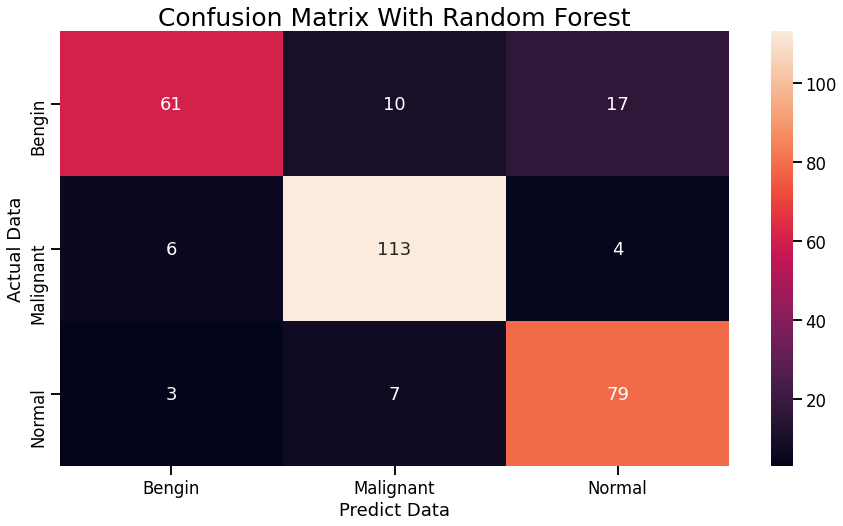

In [15]:
classification_CM_report(y_test_converted, y_pred_rf_converted, classes, "Confusion Matrix With Random Forest")

              precision    recall  f1-score   support

      Bengin       0.77      0.74      0.76        88
   Malignant       0.89      0.92      0.90       123
      Normal       0.85      0.85      0.85        89

    accuracy                           0.85       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.85      0.85      0.85       300



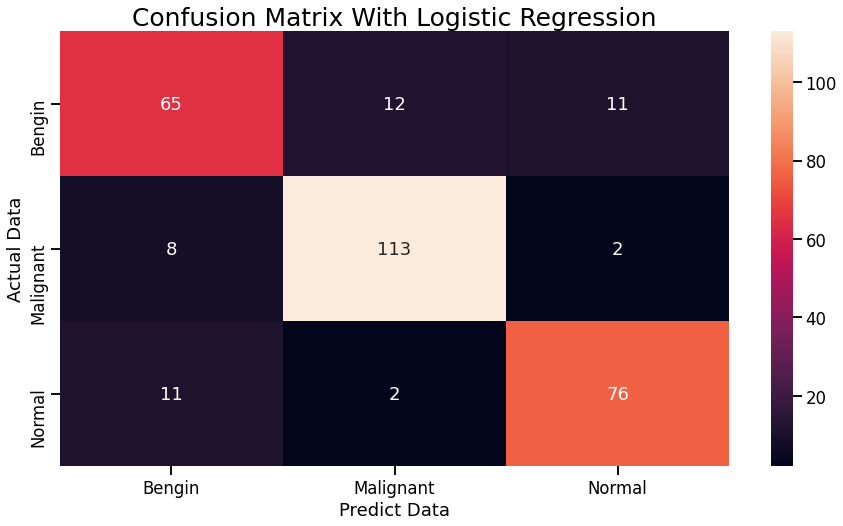

In [16]:
classification_CM_report(y_test_converted, y_pred_lr_converted, classes, "Confusion Matrix With Logistic Regression")

              precision    recall  f1-score   support

      Bengin       1.00      0.25      0.40        88
   Malignant       0.45      1.00      0.62       123
      Normal       1.00      0.06      0.11        89

    accuracy                           0.50       300
   macro avg       0.82      0.44      0.38       300
weighted avg       0.77      0.50      0.40       300



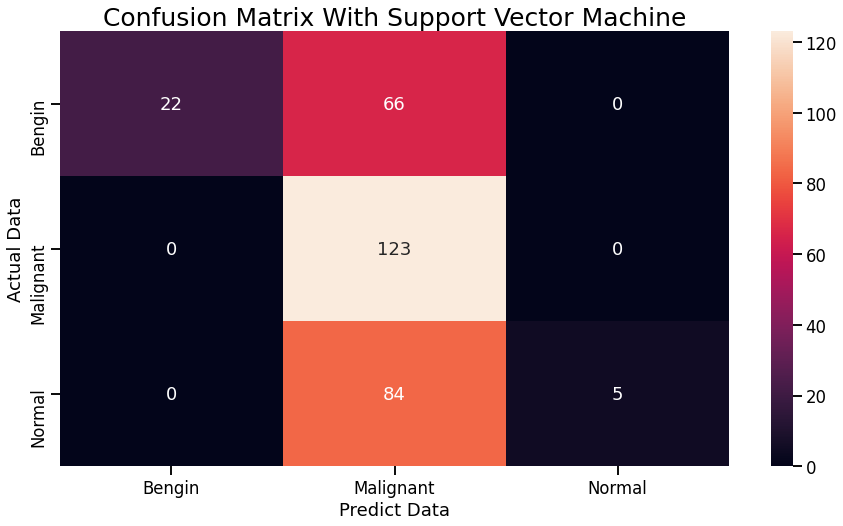

In [17]:
classification_CM_report(y_test_converted, y_pred_svm_converted, classes, "Confusion Matrix With Support Vector Machine")

In [21]:
X_dl_test_segmented.shape

(300, 128, 128, 1)

In [39]:
cnn_svm = models.Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, CHANNEL)),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
    
        #dense network
        #CNN middle layer no need to specify the shape because the network can figure it out automatically
        layers.Flatten(),
    ])

X_full_cnn_svm = cnn_svm.predict(X_dl_segmented_resize)

In [40]:
X_full_cnn_svm.shape

(1385, 9216)

In [41]:
xtr_hybird, xts_hybird, ytr_hybird, yts_hybird = train_test_split(X_full_cnn_svm, y_rscv[0], test_size=math.floor(len(X_dl_segmented_resize)*0.2167), 
                                               random_state = np.random.randint(1,1000, 1)[0])

# carefully!!!

# carefully!!!

# carefully!!!

# carefully!!!

# carefully!!!

# carefully!!!

# carefully!!!

In [12]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 6)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
space = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = space, n_iter = 100, cv = 3, verbose=10, scoring='accuracy', random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_full_cnn_svm, y_rscv[0])
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': False}

In [45]:
cnn_rf = RandomForestClassifier()
cal_print_accuracy_crossValidate(cnn_rf, X_full_cnn_svm, y_rscv[0], 'Hybird CNN-RF', cv=5)

Accuracy with cross validation
Mean and Standard Deviation of Hybird CNN-RF classifier on test set: 0.9069, 0.0358


In [46]:
cnn_svm = SVC()
cal_print_accuracy_crossValidate(cnn_svm, X_full_cnn_svm, y_rscv[0], 'Hybird CNN-SVM', cv=5)

Accuracy with cross validation
Mean and Standard Deviation of Hybird CNN-SVM classifier on test set: 0.8274, 0.0346


In [42]:
cnn_lr = LogisticRegression()
cal_print_accuracy_crossValidate(cnn_lr, X_full_cnn_svm, y_rscv[0], 'Hybird CNN-LR', cv=5)

Accuracy with cross validation
Mean and Standard Deviation of Hybird CNN-LR classifier on test set: 0.9249, 0.0355


In [23]:
cnn_rf_bestParam = RandomForestClassifier(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 2,
                            max_features = 'sqrt', max_depth = 80, bootstrap = False)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
# Fit the random search model
cnn_rf_bestParam.fit(xtr_hybird, ytr_hybird)

y_pred_cnn_rf_bestParam = cnn_rf_bestParam.predict(xts_hybird)
cnn_rf_bestParam_segmented_score = accuracy_score(yts_hybird, y_pred_cnn_rf_bestParam)
print('Random Forest Accuracy: ', cnn_rf_bestParam_segmented_score)

filename = 'best_model/best_model_cnn_rf.sav'
pickle.dump(cnn_rf_bestParam, open(filename, 'wb'))

Random Forest Accuracy:  0.9133333333333333


In [49]:
cnn_rf_bestParam = RandomForestClassifier(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 2,
                            max_features = 'sqrt', max_depth = 60, bootstrap = False)
cal_print_accuracy_crossValidate(cnn_rf_bestParam, X_full_cnn_svm, y_rscv[0], 'Hybird CNN-RF', cv=5)

Accuracy with cross validation
Mean and Standard Deviation of Hybird CNN-RF classifier on test set: 0.9256, 0.0322


In [68]:
lr = LogisticRegression()

# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [0.001, 0.01, 0.1, 0.2, 0.5, 0.7, 1, 2, 3, 4, 5, 6, 7]

lr_random = RandomizedSearchCV(estimator = lr, param_distributions = space, n_iter=100, cv = 3, verbose=10, scoring='accuracy', random_state=42, n_jobs = -1)
lr_random.fit(X_full_cnn_svm, y_rscv[0])
lr_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.7}

In [50]:
cnn_lr_bestParam = LogisticRegression(solver = 'lbfgs', penalty = 'l2', C = 0.7)
cal_print_accuracy_crossValidate(cnn_lr_bestParam, X_full_cnn_svm, y_rscv[0], 'Hybird CNN-LR', cv=5)

Accuracy with cross validation
Mean and Standard Deviation of Hybird CNN-LR classifier on test set: 0.9321, 0.0340


In [15]:
svm = SVC()

# defining parameter range
space = {'C': [0.01, 0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'degree' : [1, 2, 3, 4, 5, 6, 7],
              'kernel': ['rbf', 'linear', 'poly']} 

svm_random = RandomizedSearchCV(estimator = svm, param_distributions = space, n_iter=100, cv = 3, verbose=3, scoring='accuracy', random_state=42, n_jobs = -1)
svm_random.fit(X_full_cnn_svm, y_rscv[0])
svm_random.best_params_

Fitting 3 folds for each of 80 candidates, totalling 240 fits


{'kernel': 'linear', 'gamma': 0.1, 'degree': 3, 'C': 1}

In [47]:
cnn_svm_bestParam = SVC(kernel = 'linear', gamma = 0.1, degree = 3, C = 1)
cal_print_accuracy_crossValidate(cnn_svm_bestParam, X_full_cnn_svm, y_rscv[0], 'Hybird CNN-SVM', cv=5)

Accuracy with cross validation
Mean and Standard Deviation of Hybird CNN-SVM classifier on test set: 0.9516, 0.0074


In [45]:
cnn_rf_bestParam = RandomForestClassifier(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 2,
                            max_features = 'sqrt', max_depth = 80, bootstrap = False)
xtr_hybird, xts_hybird, ytr_hybird, yts_hybird
cnn_rf_bestParam.fit(xtr_hybird, ytr_hybird)
y_pred_cnn_rf_segmented = cnn_rf_bestParam.predict(xts_hybird)
cnn_rf_segmented_score = accuracy_score(yts_hybird, y_pred_cnn_rf_segmented)
print('Random Forest Accuracy: ', cnn_rf_segmented_score)

cnn_lr_bestParam = LogisticRegression(solver = 'lbfgs', penalty = 'l2', C = 0.7)
cnn_lr_bestParam.fit(xtr_hybird, ytr_hybird)
y_pred_cnn_lr_segmented = cnn_lr_bestParam.predict(xts_hybird)
cnn_lr_segmented_score = accuracy_score(yts_hybird, y_pred_cnn_lr_segmented)
print('Logistic Regression Accuracy: ', cnn_lr_segmented_score)

cnn_svm_bestParam = SVC(kernel = 'linear', gamma = 0.1, degree = 3, C = 1)
cnn_svm_bestParam.fit(xtr_hybird, ytr_hybird)
y_pred_cnn_svm_segmented = cnn_svm_bestParam.predict(xts_hybird)
cnn_svm_segmented_score = accuracy_score(yts_hybird, y_pred_cnn_svm_segmented)
print('Support Vector Machine(SVM) Accuracy: ', cnn_svm_segmented_score)

Random Forest Accuracy:  0.9233333333333333
Logistic Regression Accuracy:  0.95
Support Vector Machine(SVM) Accuracy:  0.95


In [27]:
# save the model to disk
filename = ['best_model/best_model_cnn_rf.sav','best_model/best_model_cnn_lr.sav','best_model/best_model_cnn_svm.sav']
best_model = [cnn_rf_bestParam,cnn_lr_bestParam,cnn_svm_bestParam]
for i in range(3):
    pickle.dump(best_model[i], open(filename[i], 'wb'))

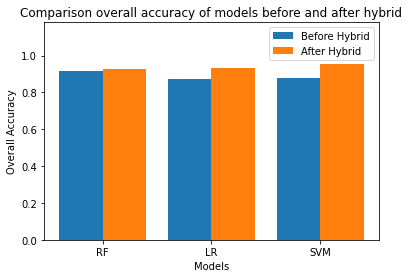

In [81]:
s = "Crime Type Summer|Crime Type Winter".split("|")

before_hybrid = [0.9141, 0.8736, 0.8773]
after_hybrid = [0.9256, 0.9321, 0.9516]

index = np.arange(3)
bar_width = 0.2

fig, ax = plt.subplots()
summer = ax.bar(index - bar_width, before_hybrid, bar_width*2,
                label="Before Hybrid")

winter = ax.bar(index + bar_width, after_hybrid,
                 bar_width*2, label="After Hybrid")

ax.set_xlabel('Models')
ax.set_ylabel('Overall Accuracy')
ax.set_title('Comparison overall accuracy of models before and after hybrid')
ax.set_xticks(index)
ax.set_xticklabels(["RF", "LR", "SVM"])
ax.axis(ymin=0,ymax=1.18)
ax.legend()

plt.show()

In [60]:
y_test_converted = [convertLabels(element, classes) for element in  yts_hybird]
#y_pred
y_pred_cnn_rf_converted = [convertLabels(element, classes) for element in y_pred_cnn_rf_segmented]
y_pred_cnn_lr_converted = [convertLabels(element, classes) for element in y_pred_cnn_lr_segmented]
y_pred_cnn_svm_converted = [convertLabels(element, classes) for element in y_pred_cnn_svm_segmented]

              precision    recall  f1-score   support

      Benign       0.97      0.97      0.97        87
   Malignant       0.93      0.96      0.95       117
      Normal       0.95      0.92      0.93        96

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



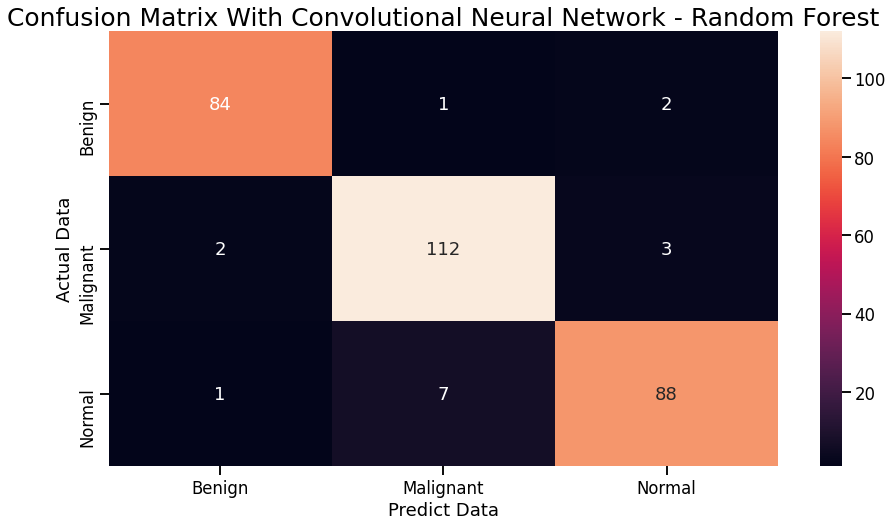

In [61]:
classification_CM_report(y_test_converted, y_pred_cnn_rf_converted, classes, "Confusion Matrix With Convolutional Neural Network - Random Forest")

              precision    recall  f1-score   support

      Benign       0.88      0.93      0.91        87
   Malignant       0.96      0.95      0.95       117
      Normal       0.96      0.92      0.94        96

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



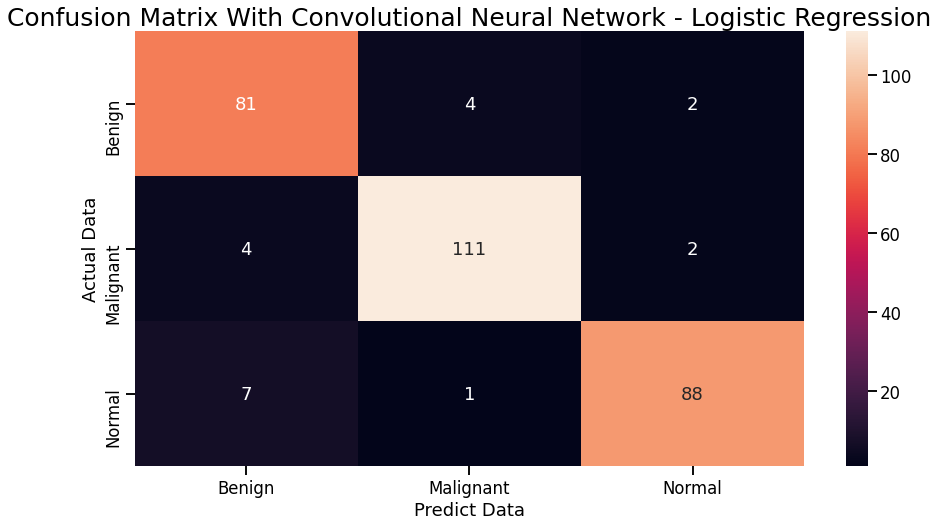

In [62]:
classification_CM_report(y_test_converted, y_pred_cnn_lr_converted, classes, "Confusion Matrix With Convolutional Neural Network - Logistic Regression")

              precision    recall  f1-score   support

      Benign       0.93      0.95      0.94        87
   Malignant       0.97      0.97      0.97       117
      Normal       0.96      0.94      0.95        96

    accuracy                           0.96       300
   macro avg       0.95      0.96      0.95       300
weighted avg       0.96      0.96      0.96       300



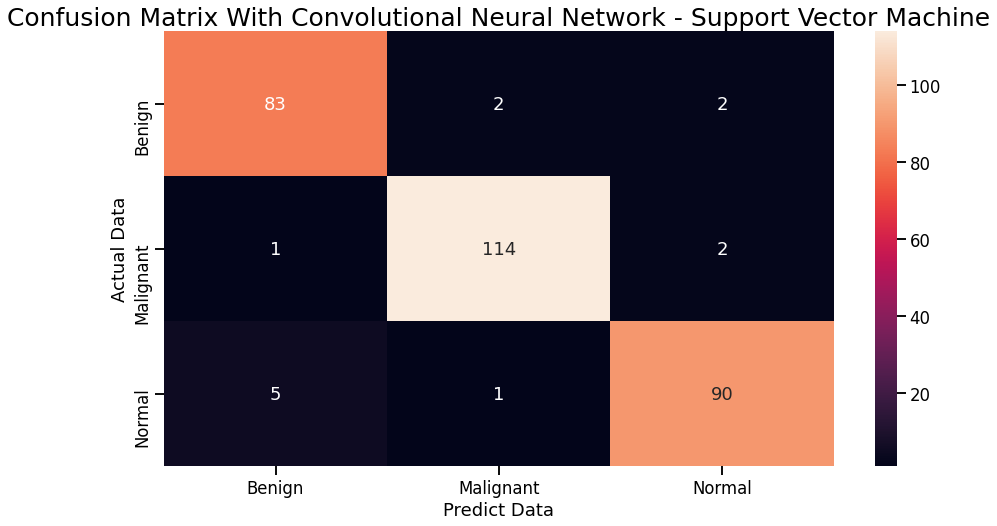

In [63]:
classification_CM_report(y_test_converted, y_pred_cnn_svm_converted, classes, "Confusion Matrix With Convolutional Neural Network - Support Vector Machine")

In [19]:
cnn_svm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       2

In [20]:
IMG_SIZE = 128
CHANNEL = 1
classes = ["Benign","Malignant","Normal"]

cnn_svm = models.Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, CHANNEL)),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
    
        #dense network
        #CNN middle layer no need to specify the shape because the network can figure it out automatically
        layers.Flatten()
    ])

# load the model from disk
#filename = ['best_model/best_model_cnn_rf.sav','best_model/best_model_cnn_lr.sav','best_model/best_model_cnn_svm.sav']
filename = 'best_model/best_model_cnn_rf.sav'
cnn_segmented = tf.keras.models.load_model('best_model/best_model_cnn_segmented.h5')
# loaded_model = pickle.load(open(filename, 'rb'))
loaded_model = joblib.load(filename)

y_pred_cnn_rf_segmented = loaded_model.predict(xts_hybird)
cnn_rf_segmented_score = accuracy_score(yts_hybird, y_pred_cnn_rf_segmented)
print('Random Forest Accuracy: ', cnn_rf_segmented_score)

Random Forest Accuracy:  0.9066666666666666


In [14]:

classes = ["Benign","Malignant","Normal"]

In [21]:
import glob
from tkinter import *
from tkinter import filedialog
from PIL import ImageTk, Image
import os
import imghdr
import cv2 as cv

root = Tk()
root.title('Lung Cancer Prediction System')
width= root.winfo_screenwidth()               
height= root.winfo_screenheight()               
root.geometry("%dx%d" %(width, height))

def openfn():
    global image_path
    filename = filedialog.askopenfilename(initialdir="test", title ="Select a CT-Scan Image", filetypes=(("jpg files","*.jpg*"),("png files","*.png"),("jpeg files","*.jpeg")))
    image_path = filename
#     return filename

def open_img():
#     img_path = openfn()
    global image_path
    openfn()
    if imghdr.what(image_path) == 'png' or imghdr.what(image_path) == 'jpeg' or imghdr.what(image_path) == 'jpg':
        img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        img = cv.resize(img, (528, 528))
        
        numOfImg = 1
        test = img.copy()
        segment_result = get_segmented_lungs(test, numOfImg, show_on_window=True, crop_percentage=float(int(clicked.get())/100))
        
        plot_on_app()
        get_prediction_result()
        
def plot_on_app():
    result_list = sorted(glob.glob('result/*.*'))
    coor_x = 82
    coor_y = 62
    for i, result_path in enumerate(result_list):
        if i == 5:
            coor_y = coor_y + 320
            coor_x = 82
        img = Image.open(result_path)
        img = img.resize((242, 242))
        image = ImageTk.PhotoImage(img)

        label_image = Label(image=image)
        label_image.image = image
        label_image.place(x=coor_x,y=coor_y)

        coor_x = coor_x + 280

def get_prediction_result():
    img = cv.imread('result/9_result.jpg', cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (128, 128))
    predict_img = np.expand_dims(img, 0)
    predict_img = predict_img.reshape(-1, 128, 128, 1)
    extraction_predict_img = cnn_svm.predict(predict_img)
    result_predict_img = loaded_model.predict(extraction_predict_img)
    result_predict_img_converted = convertLabels(result_predict_img[0], classes)
    
#     result_predict_img = cnn_segmented.predict(predict_img)
#     print(result_predict_img)
#     result_predict_img = np.argmax(result_predict_img)
#     print(result_predict_img)
#     result_predict_img_converted = convertLabels(result_predict_img, classes)
    result_label.config(text='Prediction Result : ' + str(result_predict_img_converted))
    
# Change the label text
def recrop():
    global image_path
    if image_path != '':
        img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        img = cv.resize(img, (528, 528))
        numOfImg = 1
        test = img.copy()
        get_segmented_lungs(test, numOfImg, show_on_window=True, crop_percentage=float(int(clicked.get())/100))
        plot_on_app()
        get_prediction_result()
    
coor_x = 80
coor_y = 60
for i in range(10):
    if i == 5:
        coor_y = coor_y + 320
        coor_x = 80
    Frame(root, highlightbackground="black", highlightthickness=2,width=250, height=250).place(x=coor_x, y=coor_y)
    coor_x = coor_x + 280
    
txt1 = 'Select a CT-Scan to predict ->'
Label(root, text=txt1, font=('Times', '18', 'italic')).place(x = 40, y = 10)

Button(root, text='Select a CT-Scan Image', font=('Times', '13', 'italic'), command=open_img, bg='#C7C6C1', bd=3).place(x = 350, y = 10) 
titles = ['Original Image', 'Step 1: Cropped Image', 'Step 2: Binary image', 'Step 3: Remove blobs', 'Step 4: Closure'
          , 'Step 5: Region On Interest', 'Step 6: Erosion', 'Step 7: Closure', 'Step 8: Fill Holes', 'Step 9: Segmented Result']

txt1 = 'Prediction Result : ' 
result_label = Label(root, text=txt1, font=('Times', '18', 'italic'))
result_label.place(x = 40, y = 710)

txt1 = 'Average Test Accuracy : 0.9386, Standard Deviation : 0.0246' 
Label(root, text=txt1, font=('Times', '18', 'italic')).place(x = 770, y = 690)

txt1 = 'Average Precision Score : 0.95, Average Recall Score : 0.94, Average F1 Score : 0.94'
Label(root, text=txt1, font=('Times', '18', 'italic')).place(x = 650, y = 730)

txt1 =  'Crop :            %'
Label(root, text=txt1, font=('Times', '18', 'italic')).place(x = 700, y = 10)

#txt1 = ''
#Label(root, text=text1, font=('Times', '18', 'italic')).place(x = 200, y = 700)

# Dropdown menu options
options = [
    "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10",
    "11", "12", "13", "14", "15", "16", "17", "18", "19", "20",
    "21", "22", "23", "24", "25", "26", "27", "28", "29", "30"
]
  
# datatype of menu text
clicked = StringVar()
  
# initial menu text
clicked.set( "5" )
  
# Create Dropdown menu
drop = OptionMenu( root , clicked , *options).place(x = 772, y = 10)

Button(root, text='Reload', command=recrop, font=('Times', '13', 'italic'), bg='#C7C6C1', bd=3).place(x = 890, y = 10)

coor_x = [130, 370, 660, 940, 1250, 70, 405, 690, 960, 1200]
coor_y = 310
for i in range(10):
    if i == 5:
        coor_y = coor_y + 320
    Label(root, text=titles[i], font=('Times', '18', 'italic')).place(x = coor_x[i], y = coor_y)

#variable declare
image_path = ''
    
root.mainloop()

In [57]:
img = cv.imread('result/9_result.jpg', cv.IMREAD_GRAYSCALE)
img = cv.resize(img, (128, 128))
predict_img = np.expand_dims(img, 0)
predict_img = predict_img.reshape(-1, 128, 128, 1)
cnn_segmented = tf.keras.models.load_model('best_model/best_model_cnn_segmented.h5')

# extraction_predict_img = cnn_svm.predict(predict_img)
result_predict_img = cnn_segmented.predict(predict_img)
print(result_predict_img)
result_predict_img = np.argmax(result_predict_img)
print(result_predict_img)
result_predict_img_converted = convertLabels(result_predict_img, classes)
print('Prediction Result : ' + str(result_predict_img_converted))

[[0.08139677 0.01299096 0.90561223]]
2
Prediction Result : Normal
